# Documentation

**Written:** Spencer Ressel

*** 
This script computes the buoyancy metric defined in Ahmed et al. 2020: https://doi.org/10.1175/JAS-D-19-0227.1
***

**Inputs:**
* Gridded Aqua-planet data
    - Precipitation
    - Temperature
    - Moisture

**Outputs:**
* Precipitation conditionally averaged on Buoyancy

**Dependencies:**

* /glade/u/home/sressel/aquaplanet_analysis/
    - config.py
    - load_aquaplanet_data.py

* /glade/u/home/sressel/auxiliary_functions/
    - rounding_functions.py

# Imports

In [1]:
print("Loading imports...")
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# File management
import glob
import os
import sys

# Data analysis
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
from datetime import datetime, timedelta

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import ticker as mticker
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Auxiliary functions
from config import *
sys.path.insert(0, "/glade/u/home/sressel/auxiliary_functions/")
from bmh_colors import bmh_colors
from rounding_functions import round_out
from load_aquaplanet_data import load_aquaplanet_data

print("Imports loaded")

Loading imports...
Imports loaded


# Specify analysis parameters

In [2]:
# Set latitude bounds
LATITUDE_SOUTH = -30
LATITUDE_NORTH = 30
latitude_subset_bounds = slice(LATITUDE_SOUTH, LATITUDE_NORTH)

# Set central longitude
CENTRAL_LONGITUDE = 0

# Set longitude bounds
LONGITUDE_MIN = 0
LONGITUDE_MAX = 360

# Set time bounds
START_TIME = cftime.DatetimeNoLeap(3, 1, 3, 0, 0, 0, 0, has_year_zero=True)
END_TIME = cftime.DatetimeNoLeap(13, 1, 3, 0, 0, 0, 0, has_year_zero=True)
missing_days = [
    cftime.DatetimeNoLeap(7, 2, 2, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 3, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 4, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 5, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 6, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 7, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 8, 0, 0, 0, 0, has_year_zero=True),
    cftime.DatetimeNoLeap(7, 2, 9, 0, 0, 0, 0, has_year_zero=True),
]
first_half_subset_bounds = slice(START_TIME, missing_days[0] - timedelta(days=1))
second_half_subset_bounds = slice(missing_days[-1] + timedelta(days=1), END_TIME)

# Cut-off periods for intraseasonal filtering
INTRASEASONAL_LOWCUT = 100
INTRASEASONAL_HIGHCUT = 20
frequency_subset_bounds = slice(INTRASEASONAL_LOWCUT, INTRASEASONAL_HIGHCUT)

# Cut-off wavenumbers for MJO-filtering
LARGE_SCALE_CUTOFF = 1
SMALL_SCALE_CUTOFF = 3
wavenumber_bounds = slice(LARGE_SCALE_CUTOFF, SMALL_SCALE_CUTOFF)

# Column-integrated bounds
LOWER_LEVEL_PRESSURE = 950
UPPER_LEVEL_PRESSURE = 100
pressure_subset_bounds = slice(UPPER_LEVEL_PRESSURE, LOWER_LEVEL_PRESSURE)

# Specify the experiments to load
experiments_list = ['-4K', '0K', '4K']
experiments_array = xr.DataArray(
    data=experiments_list,
    dims=["experiment"],
    coords={'experiment': experiments_list}
)

# Load data

In [5]:
print(f"{f'Loading subset data':^{str_width}}")

variables_to_load = [
    "Precipitation",
    # "Temperature",
    # "Moisture",
    # "Surface Pressure"
]

# Initialize dictionary to hold loaded data
multi_experiment_variables_subset = {}

for index, variable_name in enumerate(variables_to_load):
    # Print the variable name
    print(f"{'='*str_width}")
    print(f"{f'({index+1}/{len(variables_to_load)}) {variable_name}...':<{str_width}}")
    print(f"{'-'*str_width}")

    # Initialize a list to hold the experiment data for this variable
    variable_data_by_experiment = []

    # For each variable, loop over the experiments and find/load the data
    print("Loading data...")
    for experiment in experiments_list:
        print(f"{f'    Experiment: {experiment}':<{str_width-1}}", end="")
        file_location = rf"/glade/derecho/scratch/sressel/{experiment}/variables_subset"
        subsetted_files = glob.glob(
            f"{file_location}/{variable_name.lower().replace(' ', '_')}.nc"
        )

        # Does the variable have data?
        if subsetted_files:
            # Load in the data and append it to the list
            for index, file in enumerate(subsetted_files):
                variable_data_by_experiment.append(xr.open_dataarray(file))
            print(rf"{'✔':>1}")

        else:
            # Move on to the next variable
            print(rf"{'✘':>1}")
            print("    No data")

    # For each variable with data, concatenate the experiments into a single DataArray
    if variable_data_by_experiment:
        print(f"{'Concatenating data...':<{str_width-1}}", end="")
        multi_experiment_variables_subset[variable_name] = xr.concat(
            variable_data_by_experiment,
            dim=experiments_array,
        )
        print(rf"{'✔':>1}")
    else:
        pass

print(f"{'='*str_width}")
print("Finished")

          Loading subset data           
(1/1) Precipitation...                  
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
Finished


In [52]:
time = multi_experiment_variables_subset['Temperature'].time
latitude = multi_experiment_variables_subset['Temperature'].sel(lat=slice(-30,30)).lat
longitude = multi_experiment_variables_subset['Temperature'].lon
pressure_levels = multi_experiment_variables_subset['Temperature'].sel(
        plev=slice(100, 950)
).plev

EOF = xr.DataArray(
    data = np.empty((len(experiments_list), len(pressure_levels), len(pressure_levels))),
    dims=["experiment", "index", "plev"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(pressure_levels)+1),
        plev = pressure_levels
    )
)

PC = xr.DataArray(
    data = np.empty((len(experiments_list), len(pressure_levels), len(time), len(latitude), len(longitude))),
    dims=["experiment", "index", "time", "lat", "lon"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(pressure_levels)+1),
        time=time,
        lat=latitude,
        lon=longitude
    )
)

experiments_list = ['-4K', '0K', '4K']
for experiment_index, experiment in enumerate(experiments_list):
    compositing_variable = multi_experiment_variables_subset['Temperature'].sel(
        experiment=experiment, lat=slice(-30,30), plev=slice(100, 950)
    )
    reshaped_variable = compositing_variable.stack(timelatlon =("time", "lat", "lon")).values.T

    U, S, VT = np.linalg.svd(reshaped_variable.T, full_matrices=False)
    EOF[experiment_index] = U.T
    PC[experiment_index] = np.reshape(
        np.dot(np.diag(S), VT),
        (len(pressure_levels), len(time), len(latitude), len(longitude))
    )

(35, 5253120)

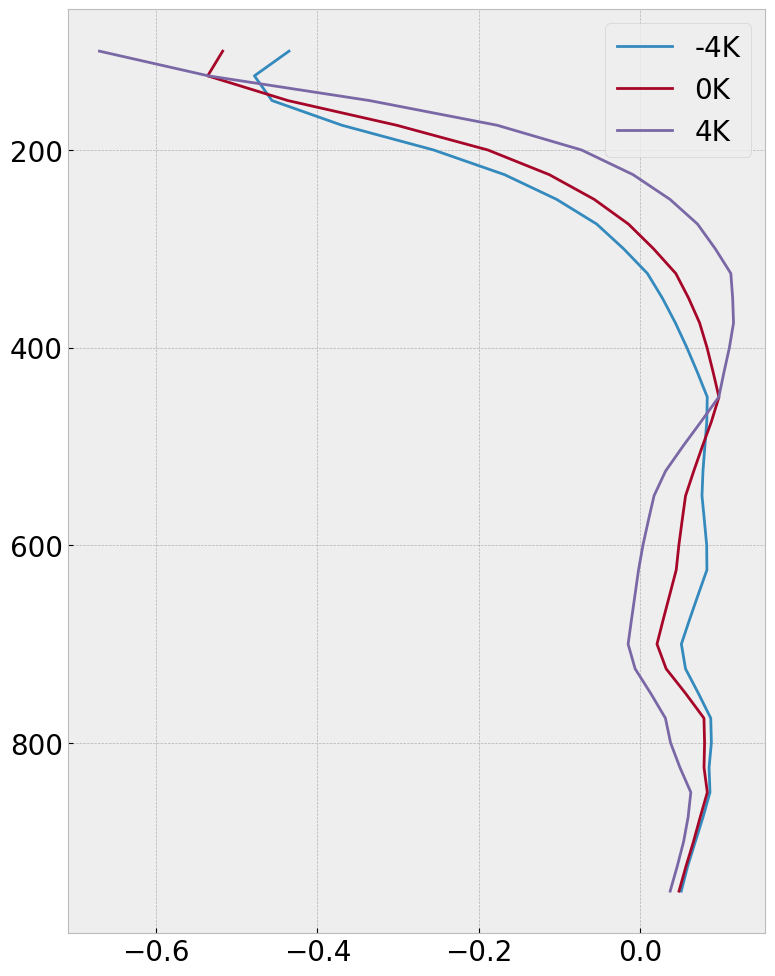

In [56]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
[fig, ax] = plt.subplots(1, 1, figsize=(9,12))
for experiment in experiments_list:
    ax.plot(
        EOF.sel(experiment=experiment, index=2),
        pressure_levels,
        label=experiment
    )

ax.legend()
ax.invert_yaxis()
# ax.axvline(x=0, color='k', ls='--')
plt.show()

In [20]:
output_directory = f"/glade/u/home/sressel/aquaplanet_analysis/output/"
savefig = False
calculate_eofs = True
plot_eofs = True

compositing_variable = multi_experiment_variables_filtered['Precipitation'].copy(deep=True)
EOF = xr.DataArray(
    data = np.empty((len(experiments_list), len(time), len(latitude), len(longitude))),
    dims=["experiment", "index", "lat", "lon"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(time)+1),
        lat=latitude,
        lon=longitude
    )
)

PC = xr.DataArray(
    data = np.empty((len(experiments_list), len(time), len(time))),
    dims=["experiment", "index", "time"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(time)+1),
        time=time
    )
)

eigenvalue_spectrum = xr.DataArray(
    data = np.empty((len(experiments_list), len(time))),
    dims=["experiment", "index"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(time)+1),
    )
)

spectrum_error = xr.DataArray(
    data = np.empty((len(experiments_list), len(time))),
    dims=["experiment", "index"],
    coords=dict(
        experiment=experiments_list,
        index=np.arange(1, len(time)+1),
    )
)

print(f"Variable: {compositing_variable.name}")

if calculate_eofs:
    for experiment_index, experiment in enumerate(experiments_list):
        print(f"{'='*40}")
        print(f"Experiment: {experiment}")
        print(f"{'='*40}")
        print("Reshaping variables...")
        reshaped_variable = np.reshape(
            compositing_variable.sel(experiment=experiment).values,
            (
                len(compositing_variable.time),
                (
                    len(compositing_variable.lat)
                    * len(compositing_variable.lon)
                ),
            ),
        )
        print("Variables reshaped")

        #### Calculate EOFs and PCs
        print("Computing EOFs...")
        U, S, VT = np.linalg.svd(reshaped_variable.T, full_matrices=False)
        EOF[experiment_index] = np.reshape(
                    U.T,
                    (
                        len(compositing_variable.time),
                        len(compositing_variable.lat),
                        len(compositing_variable.lon),
                    ),
                )
        PC[experiment_index] = np.dot(np.diag(S), VT)
        print("EOFs computed")

        # Calculate nominal degrees of freedom
        nominal_degrees_of_freedom = np.size(reshaped_variable, 1)

        # Calculate eigenvalues and spectrum
        eigenvalues = S**2 / nominal_degrees_of_freedom
        eigenvalue_spectrum[experiment_index] = eigenvalues / np.sum(eigenvalues)
        explained_variance = 100 * eigenvalue_spectrum[experiment_index]

        # Estimate 1-lag autocorrelation and effective degrees of freedom
        lag = 1
        B = 0
        for k in range(lag - 1, nominal_degrees_of_freedom - lag):
            B = B + np.sum(reshaped_variable[:, k] * reshaped_variable[:, k + lag])
        phi_L = 1 / (nominal_degrees_of_freedom - 2 * lag) * B
        phi_0 = 1 / nominal_degrees_of_freedom * np.sum(reshaped_variable**2)
        autocorrelation = phi_L / phi_0
        degrees_of_freedom = (
            (1 - autocorrelation**2) / (1 + autocorrelation**2)
        ) * nominal_degrees_of_freedom

        # Estimate uncertainty in eigenvalue spectrum
        spectrum_error[experiment_index] = (
            eigenvalue_spectrum[experiment_index]
            * np.sqrt(2 / degrees_of_freedom)
        )

else:
    print("Using pre-calculated EOFs")

print(f"{'='*40}")
print("Finished")

(35, 5253120)

# Construct Ahmed (2020) Simplified Buoyancy

In [41]:
print(f"{f'Construct buoyancy':^{str_width}}")
print(f"{'='*str_width}")

# Define the two pressure-level regions
boundary_layer = slice(850, 1000)
free_troposphere = slice(500, 850)
pressure_levels = multi_experiment_variables_subset['Moisture'].plev

# Define the exner function
print(f"{'Exner function...':<{str_width-1}}", end="")
reference_pressure = 1000 # hPa
exner_function = (pressure_levels/reference_pressure)**(DRY_AIR_GAS_CONSTANT/SPECIFIC_HEAT)

# Average over the boundary layer and lower free troposphere
boundary_layer_exner_function = exner_function.sel(plev=boundary_layer).mean(dim='plev')
free_troposphere_exner_function = exner_function.sel(plev=free_troposphere).mean(dim='plev')
print(rf"{'✔':>1}")

# Calculate the moist enthalpy
print(f"{'Moist enthalpy...':<{str_width-1}}", end="")
moist_enthalpy = (
    multi_experiment_variables_subset['Temperature']
    + (HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*multi_experiment_variables_subset['Moisture']
)
moist_enthalpy.name = 'Moist Enthalpy'

# Average over the boundary layer and lower free troposphere
boundary_layer_moist_enthalpy = moist_enthalpy.sel(plev=boundary_layer).mean(dim='plev')
boundary_layer_moist_enthalpy.name = 'Boundary Layer Moist Enthalpy'

free_troposphere_moist_enthalpy = moist_enthalpy.sel(plev=free_troposphere).mean(dim='plev')
free_troposphere_moist_enthalpy.name = 'Lower Free Troposphere Moist Enthalpy'
print(rf"{'✔':>1}")

# Calculate saturation specific humidity
print(f"{'Saturation specific humidity...':<{str_width-1}}", end="")

# Values taken from Ahmed 2020
w_B = 0.52
w_L = 1 - w_B

# mixing_ratio = specific_humidity / (1 - specific_humidity)
# partial_pressure = pressure * mixing_ratio / (epsilon + mixing_ratio)
# dewpoint_temperature = 273.15 + 243.5*np.log(partial_pressure/6.112)/(17.67 - np.log(partial_pressure/6.112))
# saturation_mixing_ratio = epsilon * (saturation_vapor_pressure)/(pressure - saturation_vapor_pressure)


saturation_vapor_pressure = 6.112 * np.exp(
    (17.67*(multi_experiment_variables_subset['Temperature']-273.15))
    / (multi_experiment_variables_subset['Temperature'] - 29.65)
)
# saturation_vapor_pressure = 6.112*np.exp(
#     (HEAT_OF_VAPORIZATION/WATER_VAPOR_GAS_CONSTANT)
#     * (1/273.15 - 1/multi_experiment_variables_subset['Temperature'])
# )
epsilon = 0.6219569100577033
saturation_specific_humidity = (HEAT_OF_VAPORIZATION/SPECIFIC_HEAT)*epsilon*saturation_vapor_pressure/pressure_levels
saturation_specific_humidity.name = 'Saturation Specific Humidity'

# Average over the lower free troposphere
free_troposphere_saturation_specific_humidity = saturation_specific_humidity.sel(
    plev=free_troposphere
).mean(dim='plev')
free_troposphere_saturation_specific_humidity.name = 'Lower Free Troposphere Saturation Specific Humidity'
print(rf"{'✔':>1}")

# Calculate saturation moist enthalpy
print(f"{'Saturation moist enthalpy...':<{str_width-1}}", end="")
saturation_moist_enthalpy = (
    multi_experiment_variables_subset['Temperature']
    + saturation_specific_humidity
)
saturation_moist_enthalpy.name = 'Saturation Moist Enthalpy'

# Average over the lower free troposphere
free_troposphere_saturation_moist_enthalpy = saturation_moist_enthalpy.sel(
    plev=free_troposphere
).mean(dim='plev')
free_troposphere_saturation_moist_enthalpy.name = 'Lower Free Troposphere Saturation Moist Enthalpy'
print(rf"{'✔':>1}")

# Calculate buoyancy
print(f"{'Buoyancy...':<{str_width-1}}", end="")
buoyancy = (
    (GRAVITY/free_troposphere_saturation_moist_enthalpy)
    * free_troposphere_exner_function
    * (
        w_B*boundary_layer_moist_enthalpy/boundary_layer_exner_function
        + (w_L*free_troposphere_moist_enthalpy - free_troposphere_saturation_moist_enthalpy)/free_troposphere_exner_function
    )
)
buoyancy.name = 'Buoyancy'
print(rf"{'✔':>1}")

# Average temperature over the lower free troposphere
free_troposphere_temperature = multi_experiment_variables_subset['Temperature'].sel(
    plev=free_troposphere
).mean(dim='plev')
free_troposphere_temperature.name = 'Lower Free Troposphere Temperature'

print(f"{'='*str_width}")
print("Finished")

           Construct buoyancy           
Exner function...                      ✔
Moist enthalpy...                      ✔
Saturation specific humidity...        ✔
Saturation moist enthalpy...           ✔
Buoyancy...                            ✔
Finished


# Conditionally average precipitation by buoyancy

In [42]:
print(f"{f'Average over buoyancy bins':^{str_width}}")
print(f"{'='*str_width}")

variable_mean_over_buoyancy = {}
buoyancy_binned = {}
fitting_indices = {}
best_fit_line = {}
bin_indices = {}

variables_to_bin = [
    (1/24)*multi_experiment_variables_subset['Precipitation'],
    # free_troposphere_saturation_specific_humidity,
    # free_troposphere_temperature,
    # boundary_layer_moist_enthalpy,
    # free_troposphere_moist_enthalpy,
    # free_troposphere_saturation_moist_enthalpy,
]

bins = np.arange(round_out(buoyancy.min().values, 2), round_out(buoyancy.max().values, 2), 0.01)
bins = np.array([np.around(bin, 2) for bin in bins])
bin_centers = np.array([(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)])

# stacked_buoyancy = buoyancy.sel(lat=slice(-20,20)).stack(flattened_data=("time", "lat", "lon"))

for experiment in ['-4K', '0K', '4K']:

    # Flatten the (time, lat, lon) buoyancy & precipitation data for a given experiment
    flattened_buoyancy_data = buoyancy.sel(
        experiment=experiment, lat=slice(-20,20)
    ).values.flatten()

    # Find the correct bin for each buoyancy value
    bin_indices[experiment] = np.digitize(flattened_buoyancy_data, bins)

    # Bin buoyancy
    # [buoyancy_binned[experiment], _] = np.histogram(flattened_buoyancy_data, bins=bins)
    buoyancy_binned[experiment] = [
            len(flattened_buoyancy_data[bin_indices[experiment] == i]) for i in range(1, len(bins))
        ]

for index, variable_data in enumerate(variables_to_bin):
    variable_name = variable_data.name
    print(f"{'-'*str_width}")
    print(f"{f'({index+1}/{len(variables_to_bin)}) {variable_name}...':<{str_width}}")

    variable_mean_over_buoyancy[variable_name] = xr.DataArray(
        data = np.empty((3, len(bin_centers))),
        dims=["experiment", "buoyancy"],
        coords=dict(
            experiment=experiments_list,
            buoyancy=bin_centers
        )
    )

    # best_fit_line[variable_name] = {}
    for experiment_index, experiment in enumerate(['-4K', '0K', '4K']):
        print(f"{f'    Experiment: {experiment}...':<{str_width-1}}", end="")

        flattened_variable_data = variable_data.sel(
                experiment=experiment, lat=slice(-20,20)
            ).values.flatten()

        # Bin precipitation by buoyancy
        variable_binned_by_buoyancy = [
            flattened_variable_data[bin_indices[experiment] == i] for i in range(1, len(bins))
        ]

        # Average the precipitation in each buoyancy bin
        variable_mean_over_buoyancy[variable_name][experiment_index][:] = np.array(
            [np.mean(bin) if bin.size > 0 else np.nan for bin in variable_binned_by_buoyancy]
        )

        print(rf"{'✔':>1}")

# alpha = xr.DataArray(
#     data=np.array([best_fit_line['Precipitation'][experiment].convert().coef[-1] for experiment in experiments_list]),
#     dims="experiment",
#     coords={'experiment': experiments_list}
# )

print(f"{'='*str_width}")
print("Finished")

       Average over buoyancy bins       
----------------------------------------
(1/1) Precipitation...                  
    Experiment: -4K...                 ✔
    Experiment: 0K...                  ✔
    Experiment: 4K...                  ✔
Finished


In [43]:
for experiment in ['-4K', '0K', '4K']:

    # Flatten the (time, lat, lon) buoyancy & precipitation data for a given experiment
    flattened_buoyancy_data = buoyancy.sel(
        experiment=experiment, lat=slice(-20,20)
    ).values.flatten()

    # Find the correct bin for each buoyancy value
    bin_indices[experiment] = np.digitize(flattened_buoyancy_data, bins)

    # Bin buoyancy
    # [buoyancy_binned[experiment], _] = np.histogram(flattened_buoyancy_data, bins=bins)
    buoyancy_binned[experiment] = [
            len(flattened_buoyancy_data[bin_indices[experiment] == i]) for i in range(1, len(bins))
        ]


In [44]:
from scipy.optimize import curve_fit
def parameterized_fit(buoyancy, critical_buoyancy, alpha):
    parameterized_precipitation = np.zeros_like(buoyancy)
    parameterized_precipitation[buoyancy < critical_buoyancy] = 0
    parameterized_precipitation[buoyancy >= critical_buoyancy] = alpha*(
        buoyancy[buoyancy >= critical_buoyancy] - critical_buoyancy
    )

    return parameterized_precipitation

In [45]:
critical_buoyancy = {}
alpha = {}
parameterized_buoyancy = {}
parameterized_precipitation = {}

for experiment in experiments_list:
    parameters = curve_fit(
        parameterized_fit,
        variable_mean_over_buoyancy['Precipitation'].dropna(dim='buoyancy').sel(experiment=experiment).buoyancy,
        variable_mean_over_buoyancy['Precipitation'].dropna(dim='buoyancy').sel(experiment=experiment),
        (0, 0.5)
    )
    critical_buoyancy[experiment] = parameters[0][0]
    alpha[experiment] = parameters[0][1]
    parameterized_buoyancy[experiment] = variable_mean_over_buoyancy['Precipitation'].dropna(dim='buoyancy').sel(experiment=experiment).buoyancy
    parameterized_precipitation[experiment] = parameterized_fit(
        parameterized_buoyancy[experiment],
        critical_buoyancy[experiment],
        alpha[experiment]
    )

alpha = xr.DataArray(
        data=np.array([alpha[experiment] for experiment in experiments_list]),
        dims="experiment",
        coords={'experiment': experiments_list}
    )

## Plot

/glade/derecho/scratch/sressel/tmp/ipykernel_46740/3273051070.py:40: RuntimeWarning: divide by zero encountered in log10
  log_bin_data = np.log10(buoyancy_binned[experiment]/np.trapz(buoyancy_binned[experiment], x=bin_centers))


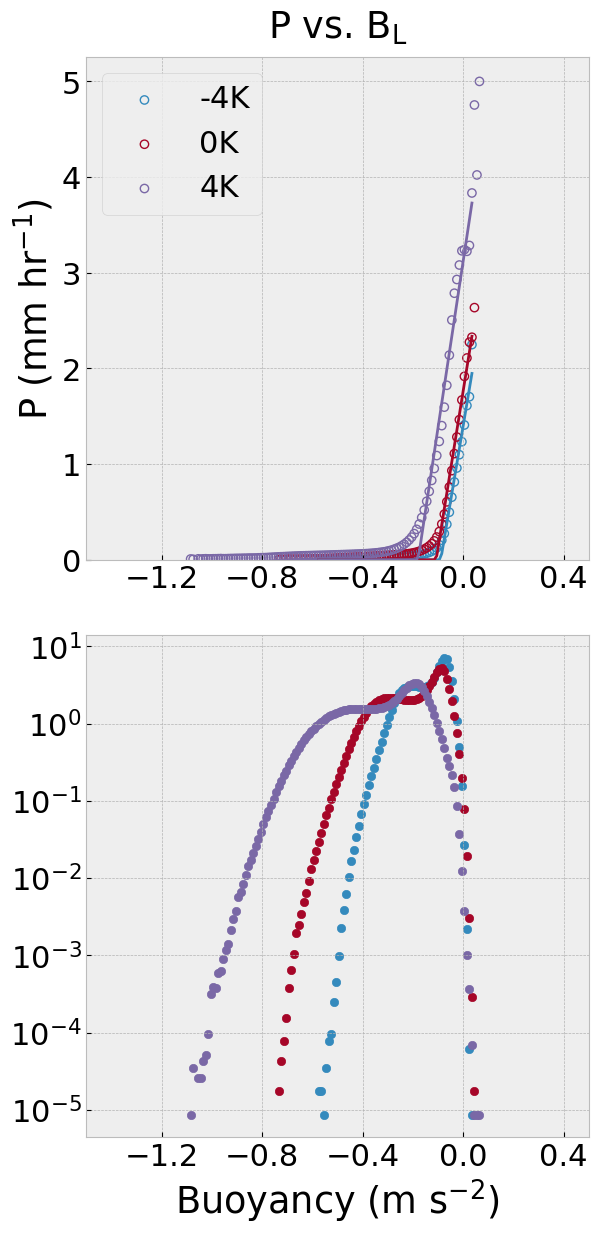

In [46]:
plt.rcParams["mathtext.default"] = 'regular'
plt.style.use('bmh')
plt.rcParams.update({'font.size':22})

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(2, 1, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.15)

ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))

fig.suptitle(r"$P$ vs. $B_{L}$", x=0.5, y=0.99)
for index,experiment in enumerate(experiments_list):

    ax[0].scatter(
        variable_mean_over_buoyancy['Precipitation'].buoyancy,
        variable_mean_over_buoyancy['Precipitation'].sel(experiment=experiment),
        label=experiment,
        edgecolors=bmh_colors(index+1),
        facecolors='none',
        lw=1
    )
    ax[0].plot(
        parameterized_buoyancy[experiment],
        parameterized_precipitation[experiment],
        color=bmh_colors(index+1),
        # marker='.'
        lw=2,
        # ls=':'
    )

    # ax[1].fill_between(
    #     bin_centers,
    #     y1=buoyancy_binned[experiment]/np.trapz(buoyancy_binned[experiment], x=bin_centers),
    #     color=bmh_colors(index+1),
    #     alpha=0.5,
    #     lw=3
    # )
    log_bin_data = np.log10(buoyancy_binned[experiment]/np.trapz(buoyancy_binned[experiment], x=bin_centers))
    ax[1].scatter(
        bin_centers,
        log_bin_data,
        # width=0.01,
        color=bmh_colors(index+1),
        # alpha=0.5,
        # lw=3
    )

ax[0].set_ylabel(r'P (mm hr$^{-1}$)')
ax[0].set_ylim(bottom=0)
ax[0].legend()
ax[1].set_xlabel('Buoyancy (m s$^{-2}$)')
ticks = np.arange(-5, 2, 1)
ticklabels = [rf"10$^{{{tick}}}$" for tick in ticks]
ax[1].set_yticks(ticks, ticklabels)

for axis in ax:
    # axis.set_ylim(bottom=0)
    axis.set_xticks(np.arange(-1.5, 1.0, 0.5))
    axis.xaxis.set_major_locator(mticker.MaxNLocator(5, prune="lower"))
    ratio = 1.0
    xleft, xright = axis.get_xlim()
    ybottom, ytop = axis.get_ylim()
    axis.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

plt.show()

# Estimating timescales

## Ahmed (2020) Values

In [ ]:
A20_alpha = 20.6
A20_ΠB = 0.97
A20_ΠL = 0.88
# A20_qL_sat = 23.43*SPECIFIC_HEAT/HEAT_OF_VAPORIZATION
A20_qL_sat = 23.43
A20_TL = 281.31
A20_eL = 300.16
A20_eLsat = 300.93
A20_eB = 332.88

A20_dBLdeB = (GRAVITY*A20_ΠL)/(A20_eLsat)*(w_B/A20_ΠB)
A20_dBLdqL = (GRAVITY)/(A20_eLsat)*(w_L)
A20_dBLdTL = -(GRAVITY/A20_eLsat)*(A20_ΠL)*(
        (
            (w_B*A20_eB/(A20_ΠB*A20_eLsat))
            + (w_L*A20_eL/(A20_ΠL*A20_eLsat))
        )*(1 + (HEAT_OF_VAPORIZATION*A20_qL_sat/(WATER_VAPOR_GAS_CONSTANT*A20_TL**2)))
        - (w_L/A20_ΠL)
    )

A20_tau_b = (SPECIFIC_HEAT/HEAT_OF_VAPORIZATION)*(800*100)/((A20_alpha*GRAVITY))*(1/A20_dBLdeB)
A20_tau_q = (SPECIFIC_HEAT/HEAT_OF_VAPORIZATION)*(800*100)/((A20_alpha*GRAVITY))*(1/A20_dBLdqL)
A20_tau_t = -(SPECIFIC_HEAT/HEAT_OF_VAPORIZATION)*(800*100)/((A20_alpha*GRAVITY))*(1/A20_dBLdTL)

## Calculate partial derivatives

In [41]:
# Calculate base-state quantities
base_state_free_troposphere_saturation_specific_humidity = free_troposphere_saturation_specific_humidity.where(
    (buoyancy > 0.015)*(buoyancy < 0.016)
).mean(dim=["time", "lat", "lon"], skipna=True)
base_state_boundary_layer_moist_enthalpy = boundary_layer_moist_enthalpy.where(
    (buoyancy > 0.015)*(buoyancy < 0.016)
).mean(dim=["time", "lat", "lon"], skipna=True)
base_state_free_troposphere_moist_enthalpy = free_troposphere_moist_enthalpy.where(
    (buoyancy > 0.015)*(buoyancy < 0.016)
).mean(dim=["time", "lat", "lon"], skipna=True)
base_state_free_troposphere_saturation_moist_enthalpy = free_troposphere_saturation_moist_enthalpy.where(
    (buoyancy > 0.015)*(buoyancy < 0.016)
).mean(dim=["time", "lat", "lon"], skipna=True)
base_state_free_troposphere_temperature = free_troposphere_temperature.where(
    (buoyancy > 0.015)*(buoyancy < 0.016)
).mean(dim=["time", "lat", "lon"], skipna=True)

# Calculate partial derivatives
dBLdeB = (
    (GRAVITY*free_troposphere_exner_function/base_state_free_troposphere_saturation_moist_enthalpy)*(w_B/boundary_layer_exner_function)
)
dBLdqL = (
    (GRAVITY/base_state_free_troposphere_saturation_moist_enthalpy)*w_L
)

term1 = (GRAVITY*free_troposphere_exner_function/base_state_free_troposphere_saturation_moist_enthalpy)
term2 = (w_B*base_state_boundary_layer_moist_enthalpy/(boundary_layer_exner_function*base_state_free_troposphere_saturation_moist_enthalpy))
term3 = (w_L*base_state_free_troposphere_moist_enthalpy/(free_troposphere_exner_function*base_state_free_troposphere_saturation_moist_enthalpy))
term4 = 1 + (HEAT_OF_VAPORIZATION*base_state_free_troposphere_saturation_specific_humidity/(WATER_VAPOR_GAS_CONSTANT*base_state_free_troposphere_temperature**2))
term5 = w_L/free_troposphere_exner_function

dBLdTL = -term1*((term2+term3)*term4-term5)

# Calculate timescales
tau_b = (SPECIFIC_HEAT/HEAT_OF_VAPORIZATION)*(800*100)/((alpha*GRAVITY))*(1/dBLdeB)
tau_q = (SPECIFIC_HEAT/HEAT_OF_VAPORIZATION)*(800*100)/((alpha*GRAVITY))*(1/dBLdqL)
tau_t = -(SPECIFIC_HEAT/HEAT_OF_VAPORIZATION)*(800*100)/((alpha*GRAVITY))*(1/dBLdTL)

## Print values

In [187]:
# Print Values
print(f"{'Exp.:':<8} {'-4K':^8} {'0K':^14} {'4K':^12} {'A20':^12}")
print(f"{'='*60}")
print(
    f"{'α:':<8} "
    + f"{alpha.sel(experiment='-4K'):>6.2f}"
    + f"{alpha.sel(experiment='0K'):>13.2f}"
    + f"{alpha.sel(experiment='4K'):>13.2f}"
    + f"{A20_alpha:>13.2f}"
)
print(
    f"{'q*_L:':<8} "
    + f"{base_state_free_troposphere_saturation_specific_humidity.sel(experiment='-4K'):>6.2f} K "
    + f"{base_state_free_troposphere_saturation_specific_humidity.sel(experiment='0K'):>10.2f} K "
    + f"{base_state_free_troposphere_saturation_specific_humidity.sel(experiment='4K'):>10.2f} K "
    + f"{A20_qL_sat:>10.2f} K "
)
print(
    f"{'T_L:':<8} "
    + f"{base_state_free_troposphere_temperature.sel(experiment='-4K'):>6.2f} K "
    + f"{base_state_free_troposphere_temperature.sel(experiment='0K'):>10.2f} K "
    + f"{base_state_free_troposphere_temperature.sel(experiment='4K'):>10.2f} K "
    + f"{A20_TL:>10.2f} K "
)
print(
    f"{'e_L:':<8} "
    + f"{base_state_free_troposphere_moist_enthalpy.sel(experiment='-4K'):>6.2f} K "
    + f"{base_state_free_troposphere_moist_enthalpy.sel(experiment='0K'):>10.2f} K "
    + f"{base_state_free_troposphere_moist_enthalpy.sel(experiment='4K'):>10.2f} K "
    + f"{A20_eL:>10.2f} K "
)
print(
    f"{'e*_L:':<8} "
    + f"{base_state_free_troposphere_saturation_moist_enthalpy.sel(experiment='-4K'):>6.2f} K "
    + f"{base_state_free_troposphere_saturation_moist_enthalpy.sel(experiment='0K'):>10.2f} K "
    + f"{base_state_free_troposphere_saturation_moist_enthalpy.sel(experiment='4K'):>10.2f} K "
    + f"{A20_eLsat:>10.2f} K "
)
print(
    f"{'e_B:':<8} "
    + f"{base_state_boundary_layer_moist_enthalpy.sel(experiment='-4K'):>6.2f} K "
    + f"{base_state_boundary_layer_moist_enthalpy.sel(experiment='0K'):>10.2f} K "
    + f"{base_state_boundary_layer_moist_enthalpy.sel(experiment='4K'):>10.2f} K "
    + f"{A20_eB:>10.2f} K "
)

print(f"{'='*60}")
print(
    f"{'τ_t':<8} "
    + f"{tau_t.sel(experiment='-4K'):>6.2f} hr "
    + f"{tau_t.sel(experiment='0K'):>9.2f} hr "
    + f"{tau_t.sel(experiment='4K'):>9.2f} hr"
    + f"{A20_tau_t:>9.2f} hr"
)
print(
    f"{'τ_q:':<8} "
    + f"{tau_q.sel(experiment='-4K'):>6.2f} hr "
    + f"{tau_q.sel(experiment='0K'):>9.2f} hr "
    + f"{tau_q.sel(experiment='4K'):>9.2f} hr"
    + f"{A20_tau_q:>9.2f} hr"
)
print(
    f"{'τ_b:':<8} "
    + f"{tau_b.sel(experiment='-4K'):>6.2f} hr "
    + f"{tau_b.sel(experiment='0K'):>9.2f} hr "
    + f"{tau_b.sel(experiment='4K'):>9.2f} hr"
    + f"{A20_tau_b:>9.2f} hr"
)
print(
    f"{'γ:':<8} "
    + f"{tau_q.sel(experiment='-4K')/tau_t.sel(experiment='-4K'):>6.2f} "
    + f"{tau_q.sel(experiment='0K')/tau_t.sel(experiment='0K'):>12.2f} "
    + f"{tau_q.sel(experiment='4K')/tau_t.sel(experiment='4K'):>12.2f} "
    + f"{A20_tau_q/A20_tau_t:>11.2f} "
)
print(
    f"{'γ_CAPE:':<8} "
    + f"{base_state_gamma_CAPE.sel(experiment='-4K'):>6.4f} "
    + f"{base_state_gamma_CAPE.sel(experiment='0K'):>12.4f} "
    + f"{base_state_gamma_CAPE.sel(experiment='4K'):>12.4f} "
    + f"{A20_tau_q/A20_tau_t:>11.2f} "
)

Exp.:      -4K          0K            4K          A20     
α:        15.90        15.79        18.28        20.60
q*_L:     12.57 K      17.95 K      24.92 K      23.43 K 
T_L:     272.12 K     277.84 K     283.14 K     281.31 K 
e_L:     284.40 K     295.69 K     309.16 K     300.16 K 
e*_L:    284.69 K     295.80 K     308.06 K     300.93 K 
e_B:     313.51 K     325.53 K     337.81 K     332.88 K 
τ_t        4.88 hr      4.16 hr      3.04 hr     2.73 hr
τ_q:      13.78 hr     14.41 hr     12.96 hr    11.24 hr
τ_b:      13.95 hr     14.59 hr     13.13 hr    11.44 hr
γ:         2.82         3.47         4.27        4.11 
γ_CAPE:  0.0040       0.0034      -0.0002 


In [181]:
gamma_CAPE = (boundary_layer_moist_enthalpy/boundary_layer_exner_function - free_troposphere_saturation_moist_enthalpy/free_troposphere_exner_function)/(free_troposphere_saturation_moist_enthalpy/free_troposphere_exner_function)
gamma_SUBSAT = ((free_troposphere_saturation_moist_enthalpy - free_troposphere_moist_enthalpy)/free_troposphere_exner_function)/(free_troposphere_saturation_moist_enthalpy/free_troposphere_exner_function)
n_L = 1 + (HEAT_OF_VAPORIZATION*base_state_free_troposphere_saturation_specific_humidity/(WATER_VAPOR_GAS_CONSTANT*base_state_free_troposphere_temperature**2))

In [183]:
base_state_gamma_CAPE = gamma_CAPE.where(
    (buoyancy > 0.015)*(buoyancy < 0.016)
).mean(dim=["time", "lat", "lon"], skipna=True)

base_state_gamma_SUBSAT = gamma_SUBSAT.where(
    (buoyancy > 0.015)*(buoyancy < 0.016)
).mean(dim=["time", "lat", "lon"], skipna=True)

base_state_n_L = n_L.where(
    (buoyancy > 0.015)*(buoyancy < 0.016)
).mean(dim=["time", "lat", "lon"], skipna=True)

print(base_state_gamma_CAPE.values)
print(base_state_gamma_SUBSAT.values)
print(base_state_n_L.values)
gamma = (2 + base_state_gamma_CAPE - base_state_gamma_SUBSAT)*base_state_n_L - 1
print(gamma.values)

[ 0.00399726  0.00336762 -0.00023702]
[ 0.00103738  0.0003592  -0.00354686]
[1.83250171 2.14010274 2.52392935]
[2.67042739 3.28664383 4.0562125 ]


# Conditionally average precipitation by CWV

In [ ]:
cwv_data = {}
mean_precip = {}
max_cwv_bin = {}
fitting_indices = {}
best_fit_line = {}
bins=np.arange(0,104,1)
for experiment in ['-4K', '0K', '4K']:
    cwv_data[experiment] = multi_experiment_variables_subset['Column Water Vapor'].sel(
            experiment=experiment, lat=slice(-20,20)
        ).values.flatten()
    [bin_counts, bin_edges] = np.histogram(cwv_data[experiment], bins=bins)
    max_cwv_bin[experiment] = np.argmax(bin_counts)

    precip_data = multi_experiment_variables_subset['Precipitation'].sel(
            experiment=experiment, lat=slice(-20,20)
        ).values.flatten()

    bin_indices = np.digitize(cwv_data[experiment], bins)

    # Step 3: Group precipitation by CWV bins
    precip_binned = [precip_data[bin_indices == i] for i in range(1, len(bins))]

    mean_precip[experiment] = [np.mean(group) for group in precip_binned]

    fitting_criteria = np.nanpercentile(mean_precip[experiment], 80)
    #fitting_criteria = mean_precip[experiment][max_cwv_bin[experiment]]
    fitting_indices[experiment] = np.where((np.array(mean_precip[experiment]) > fitting_criteria))[0]
    best_fit_line[experiment] = np.polynomial.Polynomial.fit(
        bins[slice(fitting_indices[experiment][0], fitting_indices[experiment][-1])],
        mean_precip[experiment][slice(fitting_indices[experiment][0], fitting_indices[experiment][-1])],
        deg=1
    )


In [ ]:
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

plt.style.use('bmh')
plt.rcParams.update({'font.size':22})
[fig, ax] = plt.subplots(2, 1, figsize=(8,16), sharex=True)
fig.suptitle("P vs. CWV", x=0.5, y=0.925)
for index,experiment in enumerate(mean_precip.keys()):

    ax[0].plot(
        bins[:-1],
        mean_precip[experiment],
        label=experiment,
        color=bmh_colors(index+1),
        lw=3
    )
    # ax[0].plot(
    #     bins[slice(fitting_indices[experiment][0], fitting_indices[experiment][-1])],
    #     best_fit_line[experiment].convert()(bins[slice(fitting_indices[experiment][0], fitting_indices[experiment][-1])]),
    #     color=bmh_colors(index+1),
    #     lw=5,
    #     ls=':'
    # )
    sns.kdeplot(
        cwv_data[experiment],
        ax=ax[1],
        color=bmh_colors(index+1),
        fill=bmh_colors(index+1),
    )
    # ax[1].hist(cwv_data[experiment], bins[:-1], alpha=0.5)
    # ax[1].plot(bins[:-1], cwv_data[experiment])

ax[0].set_ylabel(r'P (mm hr$^{-1}$)')
ax[0].legend()
ax[1].set_xlabel('cwv (m s$^{-2}$)')
# ax[0].set_aspect('auto')
# ax[1].set_aspect('auto')

for axis in ax:
    ratio = 1.0
    xleft, xright = axis.get_xlim()
    ybottom, ytop = axis.get_ylim()
    axis.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

# formatter = ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# formatter.set_powerlimits((3, 3))  # Fix scale to 10^4
# ax[1].yaxis.set_major_formatter(formatter)
# ax[1].ticklabel_format(axis="y", style="scientific", scilimits=(3, 3))
# ax[1].set_yticks(np.arange(0, 180000, 30000), labels=(1/1000)*np.arange(0, 180000, 30000))
# ax[1].set_ylabel('Count (x$10^{4}$)')
plt.show()

# Recreate AN18

## Define base quantities

In [66]:
pressure = multi_experiment_variables_subset['Temperature'].plev
temperature = multi_experiment_variables_subset['Temperature']
specific_humidity = multi_experiment_variables_subset['Moisture']

## Calculate vertically-resolved quantities

In [67]:
print(f"{f'Calculate potential temperature':^{str_width}}")
print(f"{'='*str_width}")

print(f"{'Preliminaries...':<{str_width-1}}", end="")
# Calculate mixing ratio from specific humidity
epsilon = 0.6219569100577033
mixing_ratio = specific_humidity / (1 - specific_humidity)
partial_pressure = pressure * mixing_ratio / (epsilon + mixing_ratio)
dewpoint_temperature = 273.15 + 243.5*np.log(partial_pressure/6.112)/(17.67 - np.log(partial_pressure/6.112))
saturation_vapor_pressure = 6.112 * np.exp((17.67*(temperature-273.15))/(temperature - 29.65))
saturation_mixing_ratio = epsilon * (saturation_vapor_pressure)/(pressure - saturation_vapor_pressure)
print(rf"{'✔':>1}")

print(f"{'LCL temperature...':<{str_width-1}}", end="")
LCL_temperature = 56 + 1. / (1. / (dewpoint_temperature - 56) + np.log(temperature / dewpoint_temperature) / 800.)
print(rf"{'✔':>1}")
print(f"{'LCL potential temperature...':<{str_width-1}}", end="")
LCL_potential_temperature = temperature*(1000/(pressure - partial_pressure))**(DRY_AIR_GAS_CONSTANT/SPECIFIC_HEAT)*(temperature/LCL_temperature)**(0.28*mixing_ratio)
print(rf"{'✔':>1}")
print(f"{'Equivalent potential temperature...':<{str_width-1}}", end="")
equivalent_potential_temperature = LCL_potential_temperature*np.exp(
    (3036 / LCL_temperature - 1.78)
    * (mixing_ratio*(1+0.448*mixing_ratio))
)
equivalent_potential_temperature.name = 'Equivalent Potential Temperature'
equivalent_potential_temperature.attrs['units'] = 'K'
equivalent_potential_temperature.attrs['short_name'] = r'$\tilde{\theta}_{e}$'

print(rf"{'✔':>1}")
print(f"{'Sat. LCL potential temperature...':<{str_width-1}}", end="")
saturation_LCL_potential_temperature = temperature*(1000/(pressure - saturation_vapor_pressure))**(DRY_AIR_GAS_CONSTANT/SPECIFIC_HEAT)
print(rf"{'✔':>1}")
print(f"{'Sat. equivalent potential temperature...':<{str_width-1}}", end="")
saturation_equivalent_potential_temperature = saturation_LCL_potential_temperature*np.exp(
        (3036 / temperature - 1.78)
    * (saturation_mixing_ratio*(1+0.448*saturation_mixing_ratio))
)
saturation_equivalent_potential_temperature.name = 'Saturation Equivalent Potential Temperature'
saturation_equivalent_potential_temperature.attrs['units'] = 'K'
saturation_equivalent_potential_temperature.attrs['short_name'] = r'$\tilde{\theta}_{e}^{*}$'

subsaturation = saturation_equivalent_potential_temperature - equivalent_potential_temperature
subsaturation.name = 'Subsaturation'
subsaturation.attrs['units'] = 'K'
subsaturation.attrs['short_name'] = r'$\tilde{\theta}_{e}^{+}$'

print(rf"{'✔':>1}")
print(f"{'='*str_width}")
print("Finished")

    Calculate potential temperature     
Preliminaries...                       ✔
LCL temperature...                     ✔
LCL potential temperature...           ✔
Equivalent potential temperature...    ✔
Sat. LCL potential temperature...      ✔
Sat. equivalent potential temperature...✔
Finished


## Calculate layer boundaries

In [68]:
experiment_mean_surface_pressure = multi_experiment_variables_subset['Surface Pressure'].mean(dim=['time', 'lat', 'lon'])

LCL_surface_temperature = LCL_temperature.sel(plev=950)
LCL_level = multi_experiment_variables_subset['Temperature'].where(multi_experiment_variables_subset['Temperature'] <= LCL_surface_temperature).idxmax(dim='plev')
experiment_mean_LCL_level = LCL_level.mean(dim=['time', 'lat', 'lon'])

freezing_level = multi_experiment_variables_subset['Temperature'].where(multi_experiment_variables_subset['Temperature'] <= 273.15).idxmax(dim='plev')
experiment_mean_freezing_level = freezing_level.sel(lat=slice(-15,15)).mean(dim=['time', 'lat', 'lon'])

experiment_mean_mid_troposphere_level = (experiment_mean_LCL_level + experiment_mean_freezing_level)/2

layer_bounds = xr.DataArray(
    data = np.array([
        [
            [experiment_mean_LCL_level.sel(experiment='-4K').values, experiment_mean_surface_pressure.sel(experiment='-4K').values],
            [experiment_mean_mid_troposphere_level.sel(experiment='-4K').values, experiment_mean_LCL_level.sel(experiment='-4K').values],
            [experiment_mean_freezing_level.sel(experiment='-4K').values, experiment_mean_mid_troposphere_level.sel(experiment='-4K').values],
        ],
        [
            [experiment_mean_LCL_level.sel(experiment='0K').values, experiment_mean_surface_pressure.sel(experiment='0K').values],
            [experiment_mean_mid_troposphere_level.sel(experiment='0K').values, experiment_mean_LCL_level.sel(experiment='0K').values],
            [experiment_mean_freezing_level.sel(experiment='0K').values, experiment_mean_mid_troposphere_level.sel(experiment='0K').values],
        ],
        [
            [experiment_mean_LCL_level.sel(experiment='4K').values, experiment_mean_surface_pressure.sel(experiment='4K').values],
            [experiment_mean_mid_troposphere_level.sel(experiment='4K').values, experiment_mean_LCL_level.sel(experiment='4K').values],
            [experiment_mean_freezing_level.sel(experiment='4K').values, experiment_mean_mid_troposphere_level.sel(experiment='4K').values],
        ]
    ]),
    dims=["experiment", "layer", "bound"],
    coords=dict(
        experiment=experiments_list,
        layer=["Boundary Layer", "Lower Troposphere", "Upper Troposphere"],
        bound=["upper", "lower"]
    )
)

## Calculate Layer-mean quantities

### Equivalent Potential Temperature

In [69]:
print("Calculating layer mean Eq. Pot. Temp.")
print(f"{'='*str_width}")

layer_mean_equivalent_potential_temperature = {}
for layer in layer_bounds.layer.values:
    print(f"Layer: {layer}")
    print(f"{'-'*str_width}")
    layer_mean_equivalent_potential_temperature[layer] = xr.zeros_like(equivalent_potential_temperature.isel(plev=0, drop=True))
    for experiment_index, experiment in enumerate(experiments_list):
        print(f"{f'{experiment}...':<{str_width-1}}", end='')
        layer_mean_equivalent_potential_temperature[layer][experiment_index] = equivalent_potential_temperature.sel(
            experiment=experiment,
            plev=slice(
                layer_bounds.sel(experiment=experiment, layer=layer, bound='upper'),
                layer_bounds.sel(experiment=experiment, layer=layer, bound='lower')
            )
        ).mean(dim='plev')
        layer_mean_equivalent_potential_temperature[layer].name = f'{layer} Equivalent Potential Temperature'
        print(rf"{'✔':>1}")

layer_mean_equivalent_potential_temperature['Boundary Layer'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eBL}\rangle$'
layer_mean_equivalent_potential_temperature['Lower Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eL}\rangle$'
layer_mean_equivalent_potential_temperature['Upper Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eM}\rangle$'
print(f"{'='*str_width}")
print("Finished")

Calculating layer mean Eq. Pot. Temp.
Layer: Boundary Layer
----------------------------------------
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Layer: Lower Troposphere
----------------------------------------
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Layer: Upper Troposphere
----------------------------------------
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Finished


### Saturation Equivalent Potential Temperature

In [70]:
print("Calculating layer mean Sat. Eq. Pot. Temp.")
print(f"{'='*str_width}")

layer_mean_saturation_equivalent_potential_temperature = {}
for layer in layer_bounds.layer.values:
    print(f"Layer: {layer}")
    print(f"{'-'*str_width}")
    layer_mean_saturation_equivalent_potential_temperature[layer] = xr.zeros_like(saturation_equivalent_potential_temperature.isel(plev=0, drop=True))
    for experiment_index, experiment in enumerate(experiments_list):
        print(f"{f'{experiment}...':<{str_width-1}}", end='')
        layer_mean_saturation_equivalent_potential_temperature[layer][experiment_index] = saturation_equivalent_potential_temperature.sel(
            experiment=experiment,
            plev=slice(
                layer_bounds.sel(experiment=experiment, layer=layer, bound='upper'),
                layer_bounds.sel(experiment=experiment, layer=layer, bound='lower')
            )
        ).mean(dim='plev')
        layer_mean_saturation_equivalent_potential_temperature[layer].name = f'{layer} Equivalent Potential Temperature'
        print(rf"{'✔':>1}")

layer_mean_saturation_equivalent_potential_temperature['Boundary Layer'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eBL}^{*}\rangle$'
layer_mean_saturation_equivalent_potential_temperature['Lower Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eL}^{*}\rangle$'
layer_mean_saturation_equivalent_potential_temperature['Upper Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eM}^{*}\rangle$'
print(f"{'='*str_width}")
print("Finished")

Calculating layer mean Sat. Eq. Pot. Temp.
Layer: Boundary Layer
----------------------------------------
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Layer: Lower Troposphere
----------------------------------------
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Layer: Upper Troposphere
----------------------------------------
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Finished


### Subsaturation

In [71]:
print("Calculating layer mean subsaturation")
print(f"{'='*str_width}")

layer_mean_subsaturation = {}
for layer in layer_bounds.layer.values:
    print(f"Layer: {layer}")
    print(f"{'-'*str_width}")
    layer_mean_subsaturation[layer] = xr.zeros_like(subsaturation.isel(plev=0, drop=True))
    for experiment_index, experiment in enumerate(experiments_list):
        print(f"{f'{experiment}...':<{str_width-1}}", end='')
        layer_mean_subsaturation[layer][experiment_index] = subsaturation.sel(
            experiment=experiment,
            plev=slice(
                layer_bounds.sel(experiment=experiment, layer=layer, bound='upper'),
                layer_bounds.sel(experiment=experiment, layer=layer, bound='lower')
            )
        ).mean(dim='plev')
        layer_mean_subsaturation[layer].name = f'{layer} Equivalent Potential Temperature'
        print(rf"{'✔':>1}")

layer_mean_subsaturation['Boundary Layer'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eBL}^{+}\rangle$'
layer_mean_subsaturation['Lower Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eL}^{+}\rangle$'
layer_mean_subsaturation['Upper Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eM}^{+}\rangle$'
print(f"{'='*str_width}")
print("Finished")

Calculating layer mean subsaturation
Layer: Boundary Layer
----------------------------------------
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Layer: Lower Troposphere
----------------------------------------
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Layer: Upper Troposphere
----------------------------------------
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Finished


In [99]:
print(layer_mean_equivalent_potential_temperature['Boundary Layer'].sel(experiment='-4K').mean().values)
print(layer_mean_equivalent_potential_temperature['Boundary Layer'].sel(experiment='0K').mean().values)
print(layer_mean_equivalent_potential_temperature['Boundary Layer'].sel(experiment='4K').mean().values)

315.07210486693515
328.3236265711742
344.54987465797365


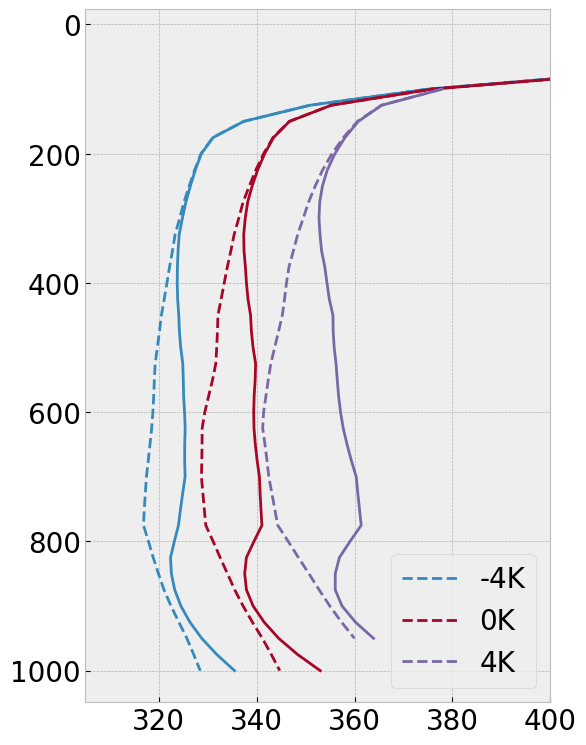

In [79]:
plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(6,9))

for index, experiment in enumerate(experiments_list):
    ax.plot(
        equivalent_potential_temperature.sel(experiment=experiment).sel(lat=slice(-15,15)).mean(dim=['time', 'lat', 'lon']),
        pressure,
        color=bmh_colors(index+1),
        ls='--',
        label=experiment
    )

    ax.plot(
        saturation_equivalent_potential_temperature.sel(experiment=experiment).sel(lat=slice(-15,15)).mean(dim=['time', 'lat', 'lon']),
        pressure,
        color=bmh_colors(index+1)
    )
ax.legend()
# ax.set_ylim(500, 1000)
ax.invert_yaxis()
ax.set_xlim(305, 400)
plt.show()

# Model-level data

## Load data

In [6]:
print(f"{f'Loading data':^{str_width}}")

subset_files = True
variable_data_by_experiment = {}
multi_experiment_variables_loaded = {}

experiments_list = ['-4K', '0K', '4K']
variables_to_load = ['T', 'Q', 'Z3', 'PS']

for index, variable_name in enumerate(variables_to_load):
    # Print the variable name
    print(f"{'='*str_width}")
    print(f"{f'({index+1}/{len(variables_to_load)}) {variable_name}...':<{str_width}}")
    print(f"{'-'*str_width}")

    # Initialize a list to hold the experiment data for this variable
    variable_data_by_experiment[variable_name] = []

    # For each variable, loop over the experiments and find/load the data
    print("Loading data...")
    for experiment in experiments_list:
        print(f"{f'    Experiment: {experiment}':<{str_width-1}}", end="")
        file_location = rf"/glade/derecho/scratch/sressel/{experiment}/daily_model-level_data"
        subset_files = glob.glob(rf"{file_location}/*{variable_name}_shifted.nc"
    )

        # Does the variable have data?
        if subset_files:
            # Append it to the list
            for index, file in enumerate(subset_files):
                variable_data_by_experiment[variable_name].append(
                    xr.open_dataset(file)[variable_name].sel(
                        time=slice(
                            cftime.DatetimeNoLeap(3, 1, 1, 0, 0, 0, 0, has_year_zero=True),
                            cftime.DatetimeNoLeap(13, 12, 31, 0, 0, 0, 0, has_year_zero=True)
                        ),
                        lat=slice(-30,30)
                    )
                )
            print(rf"{'✔':>1}")

        else:
            # Move on to the next variable
            print(rf"{'✘':>1}")
            print(f"    No data")

    # For each variable with data, concatenate the experiments into a single DataArray
    if variable_data_by_experiment[variable_name]:
        print(f"{'Concatenating data...':<{str_width-1}}", end="")
        multi_experiment_variables_loaded[variable_name] = xr.concat(
                    variable_data_by_experiment[variable_name],
                    dim=experiments_array
        )
        print(rf"{'✔':>1}")
    else:
        pass

print(f"{'='*str_width}")
print("Finished")

              Loading data              
(1/4) T...                              
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(2/4) Q...                              
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(3/4) Z3...                             
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                     ✔
    Experiment: 4K                     ✔
Concatenating data...                  ✔
(4/4) PS...                             
----------------------------------------
Loading data...
    Experiment: -4K                    ✔
    Experiment: 0K                

## Subset data

In [7]:
print(f"{f'Subsetting data':^{str_width}}")
print(f"{'='*str_width}")

# multi_experiment_variables_subset = {}

for index, (variable_name, variable_data) in enumerate(multi_experiment_variables_loaded.items()):
    print(f"{f'{variable_name}...':<{str_width-1}}", end="")
    multi_experiment_variables_subset[variable_name] = variable_data.sel(
        time=slice(
            cftime.DatetimeNoLeap(3, 2, 1, 0, 0, 0, 0, has_year_zero=True),
            cftime.DatetimeNoLeap(13, 1, 1, 0, 0, 0, 0, has_year_zero=True)
        ),
        lat=slice(-30,30)
    ).drop_sel(time=missing_days, errors='ignore')
    print(rf"{'✔':>1}")

multi_experiment_variables_subset['Precipitation'] = multi_experiment_variables_subset['Precipitation'].sel(
        time=slice(
            cftime.DatetimeNoLeap(3, 2, 1, 0, 0, 0, 0, has_year_zero=True),
            cftime.DatetimeNoLeap(13, 1, 1, 0, 0, 0, 0, has_year_zero=True)
        ),
        lat=slice(-30,30)
    ).drop_sel(time=missing_days, errors='ignore')

print(f"{'='*str_width}")
print("Finished")

            Subsetting data             
T...                                   ✔
Q...                                   ✔
Z3...                                  ✔
PS...                                  ✔
Finished


## Calculate vertical pressure array

In [8]:
print(f"{'Calculate pressure array...':<{str_width}}")
files = sorted(glob.glob("/glade/campaign/univ/uwas0114/SST_AQP3_Qobs_27_-4K_3h_10y/atm/hist/*h1*.nc"))
hyam = xr.open_dataset(files[0])['hyam']
hybm = xr.open_dataset(files[0])['hybm']
P0 = xr.open_dataset(files[0])['P0']

full_pressure_array = xr.zeros_like(multi_experiment_variables_subset['T'])
full_pressure_array[:] = (
    np.einsum(
        'm, ijkl -> ijmkl',
        P0.values*hyam.values,
        np.ones_like(multi_experiment_variables_subset['PS'].values)
    )
    + np.einsum(
        'm, ijkl -> ijmkl',
        hybm.values,
        multi_experiment_variables_subset['PS'].values
    )
)
full_pressure_array.name = 'P'
full_pressure_array.attrs['units'] = 'Pa'
print("Finished")

Calculate pressure array...             
Finished


## Calculate buoyancy precursors

In [9]:
print(f"{'Calculate Buoyancy Precursors':^{str_width}}")
print(f"{'='*str_width}")

print(f"{'Preliminaries...':<{str_width-1}}", end="")
pressure = full_pressure_array/100
temperature = multi_experiment_variables_subset['T']
specific_humidity = multi_experiment_variables_subset['Q']
geopotential_height = multi_experiment_variables_subset['Z3']
epsilon = 0.6219569100577033
mixing_ratio = specific_humidity / (1 - specific_humidity)
print(rf"{'✔':>1}")
print(f"{'-'*str_width}")

print(f"{'Equivalent Potential Temperature...':<{str_width-1}}")
print(f"{'    Partial Pressure...':<{str_width-1}}", end="")
partial_pressure = pressure * mixing_ratio / (epsilon + mixing_ratio)
print(rf"{'✔':>1}")

print(f"{'    Dewpoint Temperature...':<{str_width-1}}", end="")
dewpoint_temperature = (
    273.15 + (
        243.5
        * np.log(partial_pressure/6.112)
        / (17.67 - np.log(partial_pressure/6.112))
    )
)
print(rf"{'✔':>1}")

print(f"{'    LCL Temperature...':<{str_width-1}}", end="")
LCL_temperature = (
    56
    + 1. / (
        1. / (dewpoint_temperature - 56)
        + np.log(temperature / dewpoint_temperature) / 800.
    )
)
LCL_potential_temperature = (
    temperature
    * (1000/(pressure - partial_pressure))**(DRY_AIR_GAS_CONSTANT/SPECIFIC_HEAT)
    * (temperature/LCL_temperature)**(0.28*mixing_ratio)
)
print(rf"{'✔':>1}")

print(f"{'    Eq. Pot. Temperature...':<{str_width-1}}", end="")
equivalent_potential_temperature = LCL_potential_temperature*np.exp(
    (3036 / LCL_temperature - 1.78)
    * (mixing_ratio*(1+0.448*mixing_ratio))
)
equivalent_potential_temperature.name = 'Equivalent Potential Temperature'
equivalent_potential_temperature.attrs['units'] = 'K'
equivalent_potential_temperature.attrs['short_name'] = r'$\tilde{\theta}_{e}$'
print(rf"{'✔':>1}")
print(f"{'-'*str_width}")

print(f"{'Sat. Equivalent Potential Temperature...':<{str_width-1}}")
print(f"{'    Sat. Vapor Pressure...':<{str_width-1}}", end="")
saturation_vapor_pressure = (
    6.112
    * np.exp((17.67*(temperature-273.15))/(temperature - 29.65))
)
print(rf"{'✔':>1}")

print(f"{'    Sat. Mixing Ratio...':<{str_width-1}}", end="")
saturation_mixing_ratio = (
    epsilon
    * saturation_vapor_pressure
    / (pressure - saturation_vapor_pressure)
)
print(rf"{'✔':>1}")

print(f"{'    Sat. LCL Pot. Temp...':<{str_width-1}}", end="")
saturation_LCL_potential_temperature = (
    temperature
    * (1000/(pressure - saturation_vapor_pressure))**(DRY_AIR_GAS_CONSTANT/SPECIFIC_HEAT)
)
saturation_equivalent_potential_temperature = (
    saturation_LCL_potential_temperature
    * np.exp(
        (3036 / temperature - 1.78)
        * (saturation_mixing_ratio*(1+0.448*saturation_mixing_ratio))
    )
)
saturation_equivalent_potential_temperature.name = 'Saturation Equivalent Potential Temperature'
saturation_equivalent_potential_temperature.attrs['units'] = 'K'
saturation_equivalent_potential_temperature.attrs['short_name'] = r'$\tilde{\theta}_{e}^{*}$'
print(rf"{'✔':>1}")
print(f"{'-'*str_width}")

print(f"{'Subsaturation...':<{str_width-1}}", end="")
subsaturation = (
    saturation_equivalent_potential_temperature
    - equivalent_potential_temperature
)
subsaturation.name = 'Subsaturation'
subsaturation.attrs['units'] = 'K'
subsaturation.attrs['short_name'] = r'$\tilde{\theta}_{e}^{+}$'
print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

     Calculate Buoyancy Precursors      
Preliminaries...                       ✔
----------------------------------------
Equivalent Potential Temperature...    
    Partial Pressure...                ✔
    Dewpoint Temperature...            ✔
    LCL Temperature...                 ✔
    Eq. Pot. Temperature...            ✔
----------------------------------------
Sat. Equivalent Potential Temperature...
    Sat. Vapor Pressure...             ✔
    Sat. Mixing Ratio...               ✔
    Sat. LCL Pot. Temp...              ✔
----------------------------------------
Subsaturation...                       ✔
Finished


## Calculate Layer Boundaries

In [10]:
print(f"{f'Calculate layer boundaries':^{str_width}}")
print(f"{'='*str_width}")

print(f"{'Surface Pressure...':<{str_width-1}}", end="")
experiment_mean_surface_pressure = (1/100)*multi_experiment_variables_subset['PS'].sel(
    lat=slice(-15,15)
).mean(dim=['time', 'lat', 'lon'])
print(rf"{'✔':>1}")

print(f"{'Lifting Condensation Level...':<{str_width-1}}", end="")
LCL_level = multi_experiment_variables_subset['T'].where(
    multi_experiment_variables_subset['T'] <=  LCL_temperature.isel(lev=-1)
).idxmax(dim='lev')
experiment_mean_LCL_level = LCL_level.mean(dim=['time', 'lat', 'lon'])
print(rf"{'✔':>1}")

print(f"{'Mid Level...':<{str_width-1}}", end="")
moist_static_energy = (
    HEAT_OF_VAPORIZATION * specific_humidity
    + SPECIFIC_HEAT * temperature
    + GRAVITY * geopotential_height
)
experiment_mean_moist_static_energy = moist_static_energy.sel(
    lat=slice(-15,15)
).mean(dim=['time', 'lat', 'lon'])
experiment_mean_mid_level = experiment_mean_moist_static_energy.idxmin(dim='lev')
print(rf"{'✔':>1}")

print(f"{'Freezing Level...':<{str_width-1}}", end="")
freezing_level = multi_experiment_variables_subset['T'].where(
    multi_experiment_variables_subset['T'] <= 273.15
).idxmax(dim='lev')
experiment_mean_freezing_level = freezing_level.sel(
    lat=slice(-15,15)
).mean(dim=['time', 'lat', 'lon'])
print(rf"{'✔':>1}")

print(f"{'='*str_width}")
print("Finished")

       Calculate layer boundaries       
Surface Pressure...                    ✔
Lifting Condensation Level...          ✔
Mid Level...                           ✔
Freezing Level...                      ✔
Finished


### Plot layer-boundaries

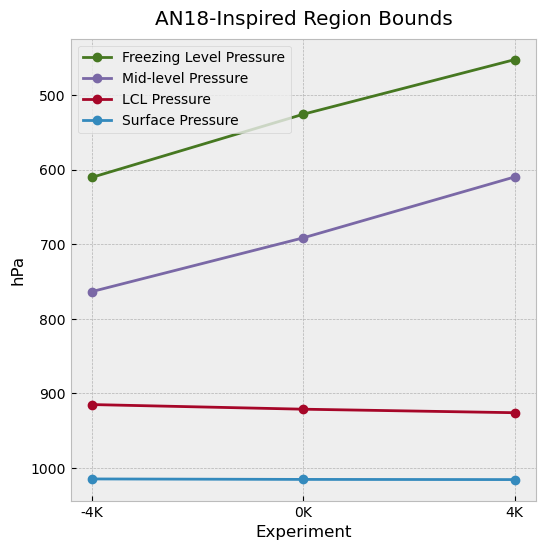

In [11]:
plt.style.use('bmh')
[fig, ax] = plt.subplots(1, 1, figsize=(6,6))
ax.set_title('AN18-Inspired Region Bounds', pad=10)
# for index, experiment in enumerate(experiments_list):
ax.plot([0,1,2], experiment_mean_freezing_level, marker='o', color=bmh_colors(4), label='Freezing Level Pressure')
ax.plot([0,1,2], experiment_mean_mid_level, marker='o', color=bmh_colors(3), label='Mid-level Pressure')
ax.plot([0,1,2], experiment_mean_LCL_level, marker='o', color=bmh_colors(2), label='LCL Pressure')
ax.plot([0,1,2], experiment_mean_surface_pressure, marker='o', color=bmh_colors(1), label='Surface Pressure')

ax.invert_yaxis()
ax.legend(loc='upper left')
ax.set_xticks([0, 1, 2], labels=experiments_list)
ax.set_ylabel('hPa')
ax.set_xlabel('Experiment')
plt.show()

In [12]:
layer_bounds = xr.DataArray(
    data = np.array([
        [
            [experiment_mean_LCL_level.sel(experiment='-4K').values, experiment_mean_surface_pressure.sel(experiment='-4K').values],
            [experiment_mean_mid_level.sel(experiment='-4K').values, experiment_mean_LCL_level.sel(experiment='-4K').values],
            [experiment_mean_freezing_level.sel(experiment='-4K').values, experiment_mean_mid_level.sel(experiment='-4K').values],
            [experiment_mean_freezing_level.sel(experiment='-4K').values, experiment_mean_LCL_level.sel(experiment='-4K').values],
        ],
        [
            [experiment_mean_LCL_level.sel(experiment='0K').values, experiment_mean_surface_pressure.sel(experiment='0K').values],
            [experiment_mean_mid_level.sel(experiment='0K').values, experiment_mean_LCL_level.sel(experiment='0K').values],
            [experiment_mean_freezing_level.sel(experiment='0K').values, experiment_mean_mid_level.sel(experiment='0K').values],
            [experiment_mean_freezing_level.sel(experiment='0K').values, experiment_mean_LCL_level.sel(experiment='0K').values],
        ],
        [
            [experiment_mean_LCL_level.sel(experiment='4K').values, experiment_mean_surface_pressure.sel(experiment='4K').values],
            [experiment_mean_mid_level.sel(experiment='4K').values, experiment_mean_LCL_level.sel(experiment='4K').values],
            [experiment_mean_freezing_level.sel(experiment='4K').values, experiment_mean_mid_level.sel(experiment='4K').values],
            [experiment_mean_freezing_level.sel(experiment='4K').values, experiment_mean_LCL_level.sel(experiment='4K').values],
        ],
    ]),
    dims=["experiment", "layer", "bound"],
    coords=dict(
        experiment=experiments_list,
        layer=["Boundary Layer", "Lower Troposphere", "Mid Troposphere", "Deep Troposphere"],
        bound=["upper", "lower"]
    )
)

## Calculate layer-mean quantities

### Equivalent Potential Temperature

In [13]:
freezing_level_saturation_equivalent_potential_temperature = saturation_equivalent_potential_temperature.sel(
    lev=freezing_level, method='nearest'
).mean(dim=['time', 'lat', 'lon'])
reference_value = 340

print("Calculating layer mean Eq. Pot. Temp.")
print(f"{'='*str_width}")

layer_mean_equivalent_potential_temperature = {}
for layer in layer_bounds.layer.values:
    print(f"Layer: {layer}")
    layer_mean_equivalent_potential_temperature[layer] = xr.zeros_like(equivalent_potential_temperature.isel(lev=-1, drop=True))
    for experiment_index, experiment in enumerate(experiments_list):
        print(f"{f'{experiment}...':<{str_width-1}}", end='')
        layer_mean_equivalent_potential_temperature[layer][experiment_index] = equivalent_potential_temperature.sel(
            experiment=experiment,
            lev=slice(
                layer_bounds.sel(experiment=experiment, layer=layer, bound='upper'),
                layer_bounds.sel(experiment=experiment, layer=layer, bound='lower')
            )
        ).mean(dim='lev') * (reference_value / freezing_level_saturation_equivalent_potential_temperature.sel(experiment=experiment))
        layer_mean_equivalent_potential_temperature[layer].name = f'{layer} Equivalent Potential Temperature'
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

layer_mean_equivalent_potential_temperature['Boundary Layer'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eBL}\rangle$'
layer_mean_equivalent_potential_temperature['Lower Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eL}\rangle$'
layer_mean_equivalent_potential_temperature['Mid Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eM}\rangle$'
layer_mean_equivalent_potential_temperature['Deep Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{ed}\rangle$'
print(f"{'='*str_width}")
print("Finished")

Calculating layer mean Eq. Pot. Temp.
Layer: Boundary Layer
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Layer: Lower Troposphere
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Layer: Mid Troposphere
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Layer: Deep Troposphere
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Finished


### Saturation Equivalent Potential Temperature

In [14]:
print("Calculating layer mean Sat. Eq. Pot. Temp.")
print(f"{'='*str_width}")

layer_mean_saturation_equivalent_potential_temperature = {}
for layer in layer_bounds.layer.values:
    print(f"Layer: {layer}")
    layer_mean_saturation_equivalent_potential_temperature[layer] = xr.zeros_like(saturation_equivalent_potential_temperature.isel(lev=-1, drop=True))
    for experiment_index, experiment in enumerate(experiments_list):
        print(f"{f'{experiment}...':<{str_width-1}}", end='')
        layer_mean_saturation_equivalent_potential_temperature[layer][experiment_index] = saturation_equivalent_potential_temperature.sel(
            experiment=experiment,
            lev=slice(
                layer_bounds.sel(experiment=experiment, layer=layer, bound='upper'),
                layer_bounds.sel(experiment=experiment, layer=layer, bound='lower')
            )
        ).mean(dim='lev') * (reference_value / freezing_level_saturation_equivalent_potential_temperature.sel(experiment=experiment))
        layer_mean_saturation_equivalent_potential_temperature[layer].name = f'{layer} Saturation Equivalent Potential Temperature'
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

layer_mean_saturation_equivalent_potential_temperature['Boundary Layer'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eBL}^{*}\rangle$'
layer_mean_saturation_equivalent_potential_temperature['Lower Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eL}^{*}\rangle$'
layer_mean_saturation_equivalent_potential_temperature['Mid Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eM}^{*}\rangle$'
layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{ed}^{*}\rangle$'
print(f"{'='*str_width}")
print("Finished")

Calculating layer mean Sat. Eq. Pot. Temp.
Layer: Boundary Layer
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Layer: Lower Troposphere
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Layer: Mid Troposphere
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Layer: Deep Troposphere
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Finished


### Subsaturation

In [15]:
print("Calculating layer mean subsaturation")
print(f"{'='*str_width}")

layer_mean_subsaturation = {}
for layer in layer_bounds.layer.values:
    print(f"Layer: {layer}")
    layer_mean_subsaturation[layer] = xr.zeros_like(subsaturation.isel(lev=-1, drop=True))
    for experiment_index, experiment in enumerate(experiments_list):
        print(f"{f'{experiment}...':<{str_width-1}}", end='')
        layer_mean_subsaturation[layer][experiment_index] = subsaturation.sel(
            experiment=experiment,
            lev=slice(
                layer_bounds.sel(experiment=experiment, layer=layer, bound='upper'),
                layer_bounds.sel(experiment=experiment, layer=layer, bound='lower')
            )
        ).mean(dim='lev') * (reference_value / freezing_level_saturation_equivalent_potential_temperature.sel(experiment=experiment))
        layer_mean_subsaturation[layer].name = f'{layer} Subsaturation'
        print(rf"{'✔':>1}")
    print(f"{'-'*str_width}")

layer_mean_subsaturation['Boundary Layer'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eBL}^{+}\rangle$'
layer_mean_subsaturation['Lower Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eL}^{+}\rangle$'
layer_mean_subsaturation['Mid Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{eM}^{+}\rangle$'
layer_mean_subsaturation['Deep Troposphere'].attrs['short_name'] = r'$\langle\tilde{\theta}_{ed}^{+}\rangle$'
print(f"{'='*str_width}")
print("Finished")

Calculating layer mean subsaturation
Layer: Boundary Layer
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Layer: Lower Troposphere
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Layer: Mid Troposphere
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Layer: Deep Troposphere
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
----------------------------------------
Finished


In [16]:
print(layer_mean_equivalent_potential_temperature['Boundary Layer'].sel(experiment='-4K').mean().values)
print(layer_mean_equivalent_potential_temperature['Boundary Layer'].sel(experiment='0K').mean().values)
print(layer_mean_equivalent_potential_temperature['Boundary Layer'].sel(experiment='4K').mean().values)

339.95923
338.42346
339.5265


## Bin Precipitation by Thermodynamic Variables

In [15]:
layer_mean_equivalent_potential_temperature['Boundary Layer'] = layer_mean_equivalent_potential_temperature['Boundary Layer'].where(
    (layer_mean_equivalent_potential_temperature['Boundary Layer'].time < missing_days[0]) | (layer_mean_equivalent_potential_temperature['Boundary Layer'].time > missing_days[-1]),
    drop=True
)

layer_mean_subsaturation['Lower Troposphere'] = layer_mean_subsaturation['Lower Troposphere'].where(
    (layer_mean_subsaturation['Lower Troposphere'].time < missing_days[0]) | (layer_mean_subsaturation['Lower Troposphere'].time > missing_days[-1]),
    drop=True
)

layer_mean_subsaturation['Mid Troposphere'] = layer_mean_subsaturation['Mid Troposphere'].where(
    (layer_mean_subsaturation['Mid Troposphere'].time < missing_days[0]) | (layer_mean_subsaturation['Mid Troposphere'].time > missing_days[-1]),
    drop=True
)

layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'] = layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'].where(
    (layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'].time < missing_days[0]) | (layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'].time > missing_days[-1]),
    drop=True
)

multi_experiment_variables_subset['Precipitation'] = multi_experiment_variables_subset['Precipitation'].where(
    (multi_experiment_variables_subset['Precipitation'].time < missing_days[0]) | (multi_experiment_variables_subset['Precipitation'].time > missing_days[-1]),
    drop=True
)

In [215]:
# print(f"{f'Average over thermodynamic quantity bins':^{str_width}}")
# print(f"{'='*str_width}")

# mean_precipitation_by_variable = {}
# bin_variable_binned = {}
# fitting_indices = {}
# best_fit_line = {}
# bin_indices = {}
# bin_centers = {}
# bins = {}

# variables_to_bin_by = [
#     layer_mean_equivalent_potential_temperature['Boundary Layer'],
#     layer_mean_subsaturation['Lower Troposphere'],
#     layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'],
# ]

# for bin_variable in variables_to_bin_by:
#     print(f"Binning Variable: {bin_variable.name}")

#     bins[bin_variable.name] = np.linspace(bin_variable.min(), bin_variable.max(), 100)
#     bin_centers[bin_variable.name] = np.array([(bins[bin_variable.name][i] + bins[bin_variable.name][i+1])/2 for i in range(len(bins[bin_variable.name])-1)])

#     bin_variable_binned[bin_variable.name] = {}
#     bin_indices[bin_variable.name] = {}
#     for experiment in ['-4K', '0K', '4K']:

#         # Flatten the (time, lat, lon) buoyancy & precipitation data for a given experiment
#         flattened_bin_variable_data = bin_variable.sel(
#             experiment=experiment, lat=slice(-15,15)
#         ).values.flatten()

#         # Find the correct bin for each buoyancy value
#         bin_indices[bin_variable.name][experiment] = np.digitize(flattened_bin_variable_data, bins[bin_variable.name])

#         # Bin buoyancy
#         # [buoyancy_binned[experiment], _] = np.histogram(flattened_buoyancy_data, bins=bins)
#         bin_variable_binned[bin_variable.name][experiment] = [
#                 len(flattened_bin_variable_data[bin_indices[bin_variable.name][experiment] == i]) for i in range(1, len(bins[bin_variable.name]))
#             ]

#     mean_precipitation_by_variable[bin_variable.name] = xr.DataArray(
#         data = np.empty((3, len(bin_centers[bin_variable.name]))),
#         dims=["experiment", "bin_centers"],
#         coords=dict(
#             experiment=experiments_list,
#             bin_centers=bin_centers[bin_variable.name]
#         )
#     )

#     # best_fit_line[variable_name] = {}
#     for experiment_index, experiment in enumerate(['-4K', '0K', '4K']):
#         print(f"{f'    Experiment: {experiment}...':<{str_width-1}}", end="")

#         flattened_precipitation_data = (1/24)*multi_experiment_variables_subset['Precipitation'].sel(
#             experiment=experiment, lat=slice(-15,15)
#         ).values.flatten()

#         # Bin precipitation by buoyancy
#         precipitation_binned_by_variable = [
#             flattened_precipitation_data[bin_indices[bin_variable.name][experiment] == i] for i in range(1, len(bins[bin_variable.name]))
#         ]

#         # Average the precipitation in each buoyancy bin
#         mean_precipitation_by_variable[bin_variable.name][experiment_index][:] = np.array(
#             [np.mean(bin) if bin.size > 0 else np.nan for bin in precipitation_binned_by_variable]
#         )

#         print(rf"{'✔':>1}")

#     # alpha = xr.DataArray(
#     #     data=np.array([best_fit_line['Precipitation'][experiment].convert().coef[-1] for experiment in experiments_list]),
#     #     dims="experiment",
#     #     coords={'experiment': experiments_list}
#     # )

# print(f"{'='*str_width}")
# print("Finished")

In [103]:
variables_to_bin_by = [
    layer_mean_equivalent_potential_temperature['Boundary Layer'],
    layer_mean_subsaturation['Lower Troposphere'],
    layer_mean_subsaturation['Mid Troposphere'],
    layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'],
]

bins = {}
bin_centers = {}

bins['Boundary Layer Equivalent Potential Temperature'] = np.arange(
    np.floor(layer_mean_equivalent_potential_temperature['Boundary Layer'].min()),
    np.ceil(layer_mean_equivalent_potential_temperature['Boundary Layer'].max()),
    2
)
bins['Lower Troposphere Subsaturation'] = np.arange(
    # np.floor(layer_mean_subsaturation['Lower Troposphere'].min()),
    0,
    np.ceil(layer_mean_subsaturation['Lower Troposphere'].max()),
    0.5
)
bins['Mid Troposphere Subsaturation'] = np.arange(
    np.floor(layer_mean_subsaturation['Mid Troposphere'].min()),
    np.ceil(layer_mean_subsaturation['Mid Troposphere'].max()),
    2
)
bins['Deep Troposphere Saturation Equivalent Potential Temperature'] = np.arange(
    np.floor(layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'].min()),
    np.ceil(layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'].max()),
    2
)

for bin_variable in variables_to_bin_by:
    print(f"Binning Variable: {bin_variable.name}")

    # bins[bin_variable.name] = np.linspace(bin_variable.min(), bin_variable.max(), 100)
    bin_centers[bin_variable.name] = np.array([(bins[bin_variable.name][i] + bins[bin_variable.name][i+1])/2 for i in range(len(bins[bin_variable.name])-1)])


Binning Variable: Boundary Layer Equivalent Potential Temperature
Binning Variable: Lower Troposphere Subsaturation
Binning Variable: Mid Troposphere Subsaturation
Binning Variable: Deep Troposphere Saturation Equivalent Potential Temperature


In [104]:
print(f"{f'Bin Precipitation Data':^{str_width}}")
print(f"{'='*str_width}")

from scipy import stats
binned_data = {}

for experiment in experiments_list:
    print(f"{f'{experiment}...':<{str_width-1}}", end='')
    binned_data[experiment] = stats.binned_statistic_dd(
        sample = [
            layer_mean_equivalent_potential_temperature['Boundary Layer'].sel(experiment=experiment).values.flatten(),
            layer_mean_subsaturation['Lower Troposphere'].sel(experiment=experiment).values.flatten(),
            layer_mean_subsaturation['Mid Troposphere'].sel(experiment=experiment).values.flatten(),
            layer_mean_saturation_equivalent_potential_temperature['Deep Troposphere'].sel(experiment=experiment).values.flatten(),
        ],
        values = (1/24)*multi_experiment_variables_subset['Precipitation'].sel(experiment=experiment).values.flatten(),
        expand_binnumbers=True,
        bins=[
            bins['Boundary Layer Equivalent Potential Temperature'],
            bins['Lower Troposphere Subsaturation'],
            bins['Mid Troposphere Subsaturation'],
            bins['Deep Troposphere Saturation Equivalent Potential Temperature'],
        ]
    )
    print(rf"{'✔':>1}")
print("Finished")

         Bin Precipitation Data         
-4K...                                 ✔
0K...                                  ✔
4K...                                  ✔
Finished


In [17]:
print(f"{f'Bin Precipitation Data':^{str_width}}")
print(f"{'='*str_width}")

from scipy import stats
binned_data = {}

for experiment in experiments_list:
    print(f"{f'{experiment}...':<{str_width-1}}", end='')
    binned_data[experiment] = stats.binned_statistic_dd(
        sample = [
            layer_mean_equivalent_potential_temperature['Boundary Layer'].sel(experiment=experiment).values.flatten(),
        ],
        values = (1/24)*multi_experiment_variables_subset['Precipitation'].sel(experiment=experiment).values.flatten(),
        expand_binnumbers=True,
        bins=[
            bins['Boundary Layer Equivalent Potential Temperature'],
        ]
    )
    print(rf"{'✔':>1}")
print("Finished")

         Bin Precipitation Data         
-4K...                                 

NameError: name 'bins' is not defined

In [105]:
precip_binned = xr.DataArray(
    data=[
        binned_data['-4K'].statistic,
        binned_data['0K'].statistic,
        binned_data['4K'].statistic
    ],
    dims=["experiment", "BLEQPT", "LTSUBSAT", "MTSUBSAT", "DTSATEQPT"],
    coords=dict(
        experiment = experiments_array,
        BLEQPT=bin_centers['Boundary Layer Equivalent Potential Temperature'],
        LTSUBSAT=bin_centers['Lower Troposphere Subsaturation'],
        MTSUBSAT=bin_centers['Mid Troposphere Subsaturation'],
        DTSATEQPT=bin_centers['Deep Troposphere Saturation Equivalent Potential Temperature'],
    )
)

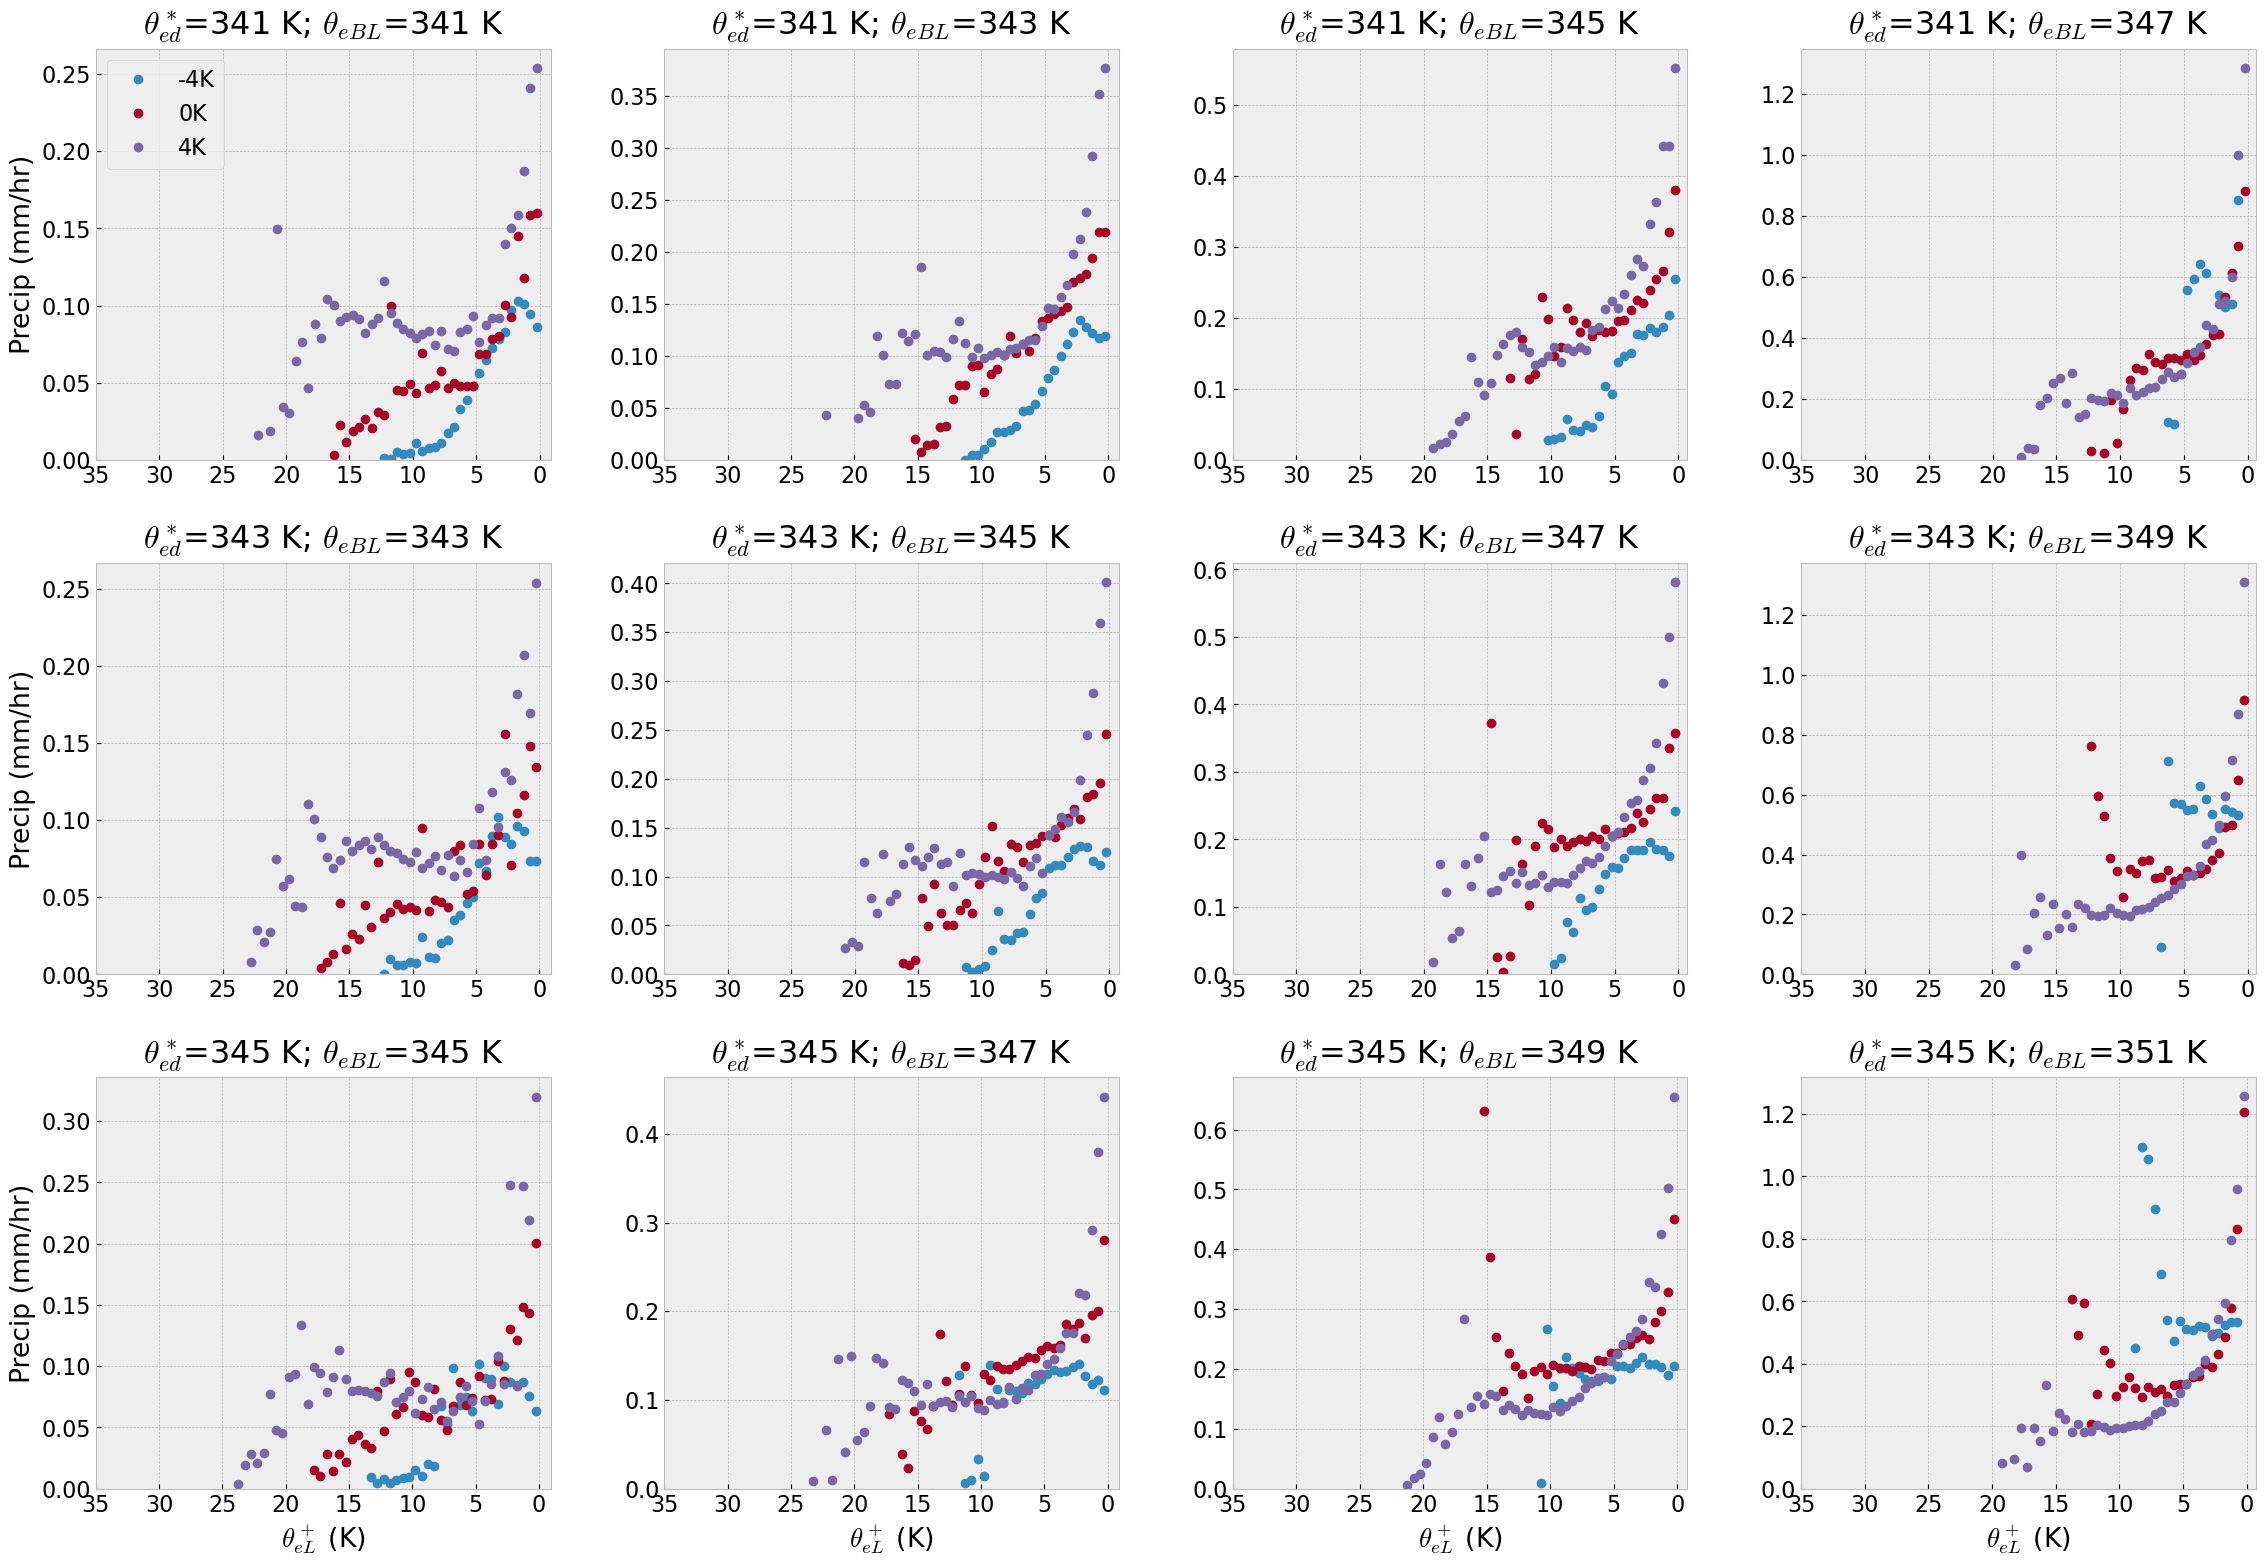

In [107]:
plt.rcParams.update({'font.size':16})
plt.style.use('bmh')
from matplotlib.gridspec import GridSpec
# fig = plt.figure(figsize=(2*11, 2*8.5))
fig = plt.figure(figsize=(24, 16))
gs = GridSpec(3, 4, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.25, wspace=0.25)
theta_ed_values = [341, 343, 345]
theta_eBL_values = [341, 343, 345, 347]

axes = []
for row_index, theta_ed in enumerate(theta_ed_values):
    for col_index, theta_eBL in enumerate(theta_eBL_values):
        ax = fig.add_subplot(gs[row_index, col_index])
        ax.set_title(rf"$\theta^{'*'}_{{{'ed'}}}$={theta_ed} K; $\theta_{{{'eBL'}}}$={theta_eBL+2*row_index} K", pad=10)
        for experiment_index, experiment in enumerate(experiments_list):
            ax.plot(
                precip_binned.LTSUBSAT,
                precip_binned.sel(experiment=experiment).sel(BLEQPT=theta_eBL+2*row_index, DTSATEQPT=theta_ed, method='nearest').mean(dim='MTSUBSAT'),
                color=bmh_colors(experiment_index+1),
                ls='none',
                marker='o',
                label=experiment
            )
        if (row_index == 0)*(col_index == 0):
            ax.legend(loc='upper left', fontsize=16)
        if row_index == 2:
            ax.set_xlabel(rf"$\theta^{'+'}_{{{'eL'}}}$ (K)")
        if col_index == 0:
            ax.set_ylabel(f"Precip (mm/hr)")
        # ax.set_ylim(0, 2)
        ax.set_ylim(bottom=0)
        # ax.set_yticks(np.arange(0, 2.5, 0.5))
        # ax.set_xlim(0, 35)
        ax.set_xticks(np.arange(0, 40, 5))
        ax.invert_xaxis()
        ax.set_aspect('auto')

plt.show()

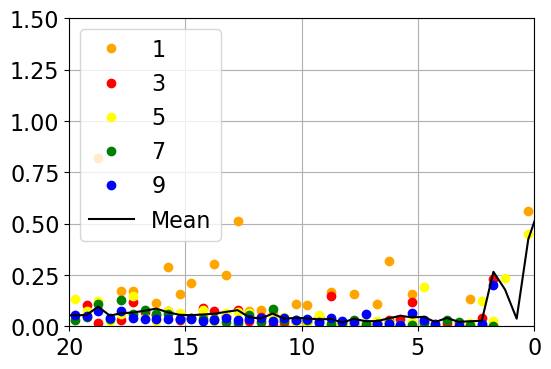

In [102]:
plt.style.use('default')
plt.rcParams.update({'font.size':16})
[fig, ax] = plt.subplots(1, 1, figsize=(6,4))

for color, theta_M in zip(['orange', 'red', 'yellow', 'green', 'blue'], [1, 3, 5, 7, 9]):
    ax.plot(
        precip_binned.LTSUBSAT,
        precip_binned.sel(experiment='4K').sel(BLEQPT=345, DTSATEQPT=347, MTSUBSAT=theta_M, method='nearest'),
        color=color,
        marker='o',
        ls='none',
        label=theta_M
    )

ax.plot(
        precip_binned.LTSUBSAT,
        precip_binned.sel(experiment='4K').sel(BLEQPT=345, DTSATEQPT=347, method='nearest').mean(dim='MTSUBSAT'),
        color='k',
        label='Mean'
    )
ax.legend(loc='upper left')
ax.grid()
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(0, 25, 5))
ax.set_ylim(0, 1.5)
# ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.invert_xaxis()
plt.show()

In [100]:
precip_binned.sel(experiment='4K').sel(BLEQPT=345, DTSATEQPT=347).mean(dim='MTSUBSAT')

<xarray.DataArray (LTSUBSAT: 81)> Size: 648B
array([1.17030901, 0.58784193, 0.42385065, 0.03697161, 0.17889227,
       0.26533827, 0.02669728, 0.02452508, 0.02170868, 0.04057073,
       0.02070568, 0.04600386, 0.0433063 , 0.05090127, 0.03884809,
       0.02512433, 0.02483055, 0.03617029, 0.01829023, 0.035928  ,
       0.03291922, 0.03890955, 0.04078419, 0.03708026, 0.06170192,
       0.03793106, 0.04370553, 0.0785818 , 0.0701291 , 0.06117781,
       0.05755663, 0.0539264 , 0.05591461, 0.06800313, 0.0859533 ,
       0.07587035, 0.06701338, 0.06368382, 0.05189739, 0.09536207,
       0.05511321, 0.053124  , 0.05415175, 0.07409321, 0.05849092,
       0.04008973, 0.03453664, 0.05081452, 0.03024926, 0.02909195,
       0.01852535, 0.06181339, 0.01408141, 0.01220613, 0.0095684 ,
       0.0224787 ,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan])
Coordinates:
    experiment  <U3 12B '4K'
    BLEQPT      float64 8B 345.0
  * LTSUBSAT    (LTSUBSAT) float64 648B -0.75 -0.25 0.25 ... 38.25 38.75 39.25
    DTSATEQPT   float64 8B 347.0

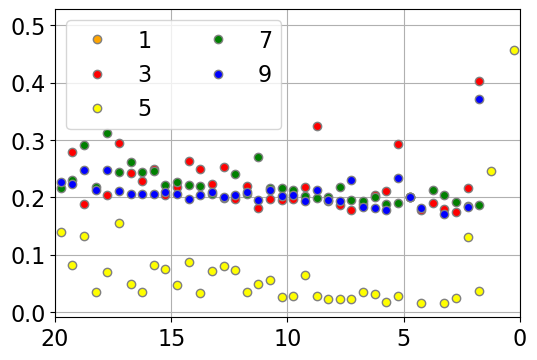

In [93]:
plt.style.use('default')
plt.rcParams.update({'font.size':16})
[fig, ax] = plt.subplots(1, 1, figsize=(6,4))

for color, theta_M in zip(['orange', 'red', 'yellow', 'green', 'blue'], [1, 3, 5, 7, 9]):
    target_loc = np.where(precip_binned.LTSUBSAT <= 5)[0][-1]
    ax.plot(
        precip_binned.LTSUBSAT,
        (
            precip_binned.sel(experiment='4K').sel(BLEQPT=345, DTSATEQPT=347, MTSUBSAT=theta_M, method='nearest')
            + (
                0.2 - precip_binned.sel(experiment='4K').sel(BLEQPT=345, DTSATEQPT=347, MTSUBSAT=theta_M, method='nearest')[target_loc]

              )
        ),
        color=color,
        marker='o',
        markeredgecolor ='gray',
        ls='none',
        label=theta_M
    )
ax.legend(loc='upper left', ncol=2)
ax.grid()
ax.set_xlim(0, 20)
ax.set_xticks(np.arange(0, 25, 5))
# ax.set_ylim(0, 1)
# ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.invert_xaxis()
plt.show()

In [81]:
precip_binned.LTSUBSAT[target_loc]

<xarray.DataArray 'LTSUBSAT' ()> Size: 8B
array(9.75)
Coordinates:
    LTSUBSAT  float64 8B 9.75

In [55]:
np.where(precip_binned.sel(experiment='4K').sel(BLEQPT=349, DTSATEQPT=345, MTSUBSAT=theta_M, method='nearest')>0.3)

(array([ 1,  2,  3,  4, 36]),)

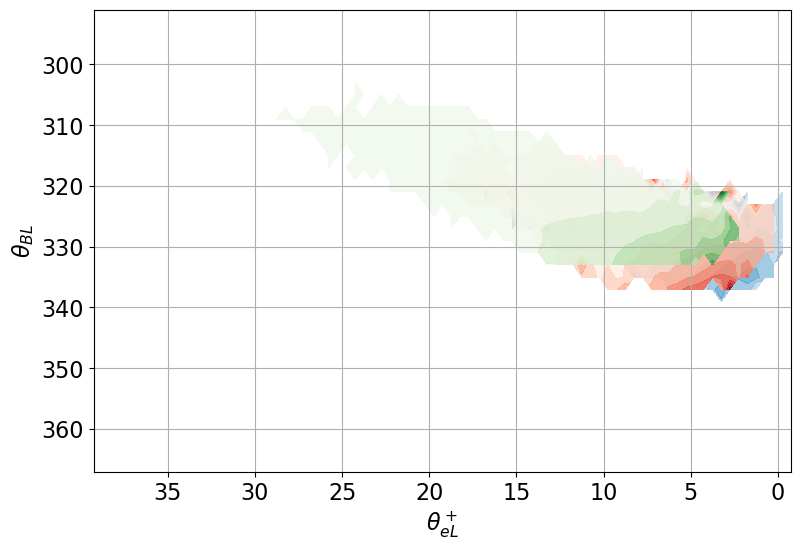

In [34]:
plt.style.use('default')
plt.rcParams.update({'font.size':16})
[fig, ax] = plt.subplots(1, 1, figsize=(9,6))
ax.contourf(
    precip_binned.LTSUBSAT,
    precip_binned.BLEQPT,
    precip_binned.sel(experiment='4K').sel(MTSUBSAT=3, DTSATEQPT=328, method='nearest'),
    alpha=0.75,
    cmap='Blues'
)
ax.contourf(
    precip_binned.LTSUBSAT,
    precip_binned.BLEQPT,
    precip_binned.sel(experiment='4K').sel(MTSUBSAT=10, DTSATEQPT=328, method='nearest'),
    alpha=0.75,
    cmap='Reds'
)
ax.contourf(
    precip_binned.LTSUBSAT,
    precip_binned.BLEQPT,
    precip_binned.sel(experiment='4K').sel(MTSUBSAT=20, DTSATEQPT=328, method='nearest'),
    alpha=0.75,
    cmap='Greens'
)
ax.set_xlabel(rf"$\theta^{'+'}_{{{'eL'}}}$")
ax.set_ylabel(rf"$\theta_{{{'BL'}}}$")
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_aspect('auto')
ax.grid(True)
plt.show()

NameError: name 'variable_mean_over_buoyancy' is not defined

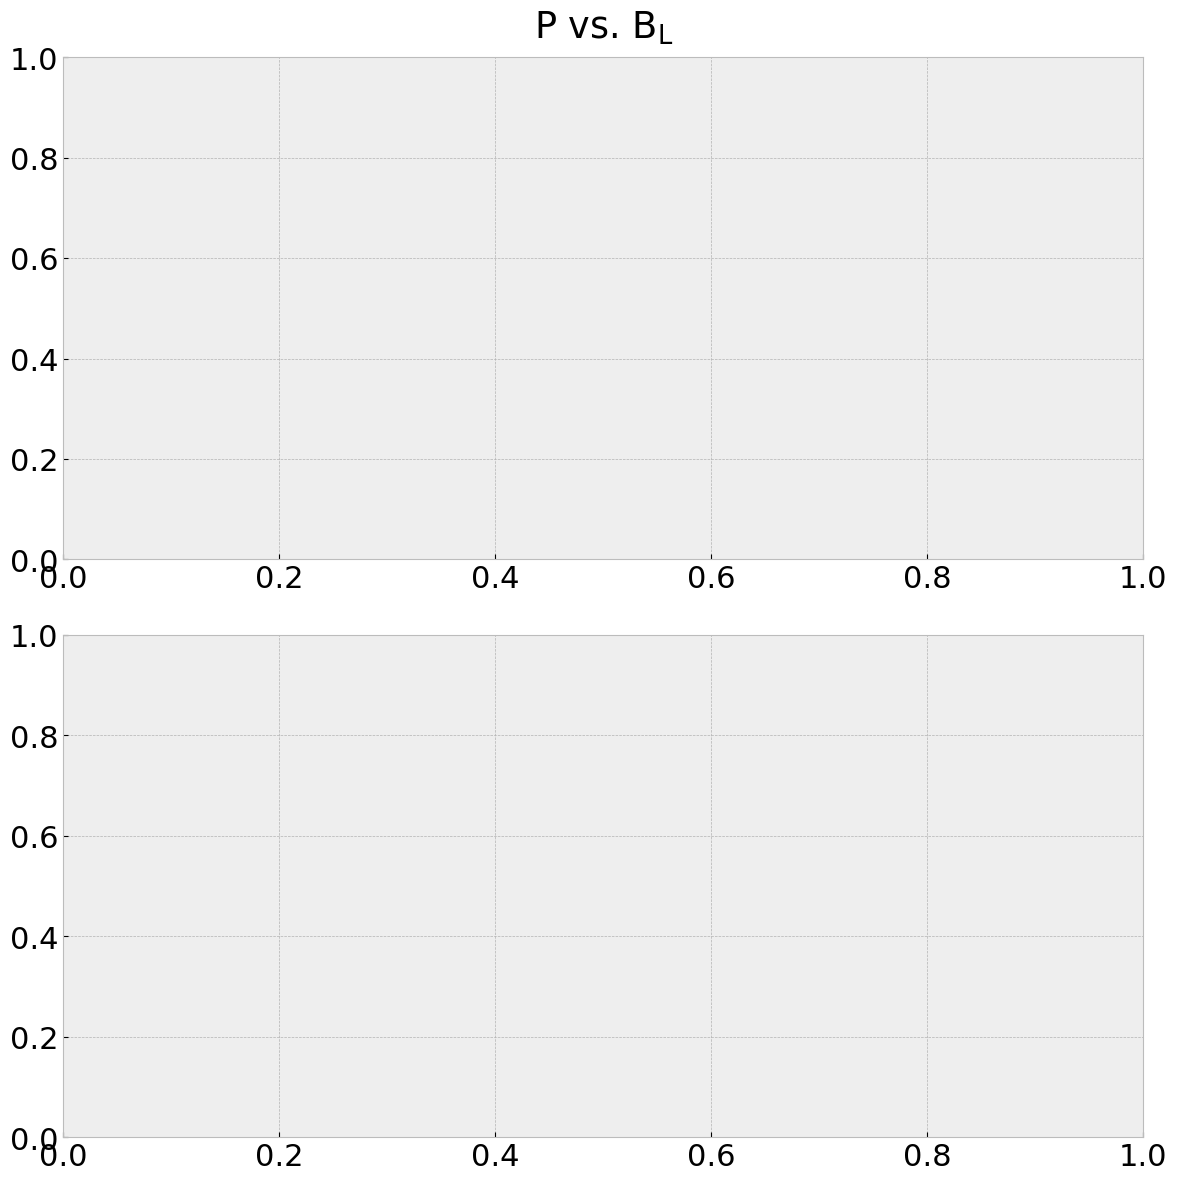

In [35]:
plt.rcParams["mathtext.default"] = 'regular'
plt.style.use('bmh')
plt.rcParams.update({'font.size':22})

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(2, 1, figure=fig)
gs.update(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=0.15)

ax = []
ax.append(fig.add_subplot(gs[0]))
ax.append(fig.add_subplot(gs[1]))

fig.suptitle(r"$P$ vs. $B_{L}$", x=0.5, y=0.99)
for index,experiment in enumerate(experiments_list):

    ax[0].scatter(
        variable_mean_over_buoyancy['Precipitation'].buoyancy,
        variable_mean_over_buoyancy['Precipitation'].sel(experiment=experiment),
        label=experiment,
        edgecolors=bmh_colors(index+1),
        facecolors='none',
        lw=1
    )
    ax[0].plot(
        parameterized_buoyancy[experiment],
        parameterized_precipitation[experiment],
        color=bmh_colors(index+1),
        # marker='.'
        lw=2,
        # ls=':'
    )

    # ax[1].fill_between(
    #     bin_centers,
    #     y1=buoyancy_binned[experiment]/np.trapz(buoyancy_binned[experiment], x=bin_centers),
    #     color=bmh_colors(index+1),
    #     alpha=0.5,
    #     lw=3
    # )
    log_bin_data = np.log10(buoyancy_binned[experiment]/np.trapz(buoyancy_binned[experiment], x=bin_centers))
    ax[1].scatter(
        bin_centers,
        log_bin_data,
        # width=0.01,
        color=bmh_colors(index+1),
        # alpha=0.5,
        # lw=3
    )

ax[0].set_ylabel(r'P (mm hr$^{-1}$)')
ax[0].set_ylim(bottom=0)
ax[0].legend()
ax[1].set_xlabel('Buoyancy (m s$^{-2}$)')
ticks = np.arange(-5, 2, 1)
ticklabels = [rf"10$^{{{tick}}}$" for tick in ticks]
ax[1].set_yticks(ticks, ticklabels)

for axis in ax:
    # axis.set_ylim(bottom=0)
    axis.set_xticks(np.arange(-1.5, 1.0, 0.5))
    axis.xaxis.set_major_locator(mticker.MaxNLocator(5, prune="lower"))
    ratio = 1.0
    xleft, xright = axis.get_xlim()
    ybottom, ytop = axis.get_ylim()
    axis.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)

plt.show()